# **Proyecto de inteligencia artificial**

## Contexto

Proyecto de inteligencia artificial

Nombre Alumno: Rodolfo Godoy Arteaga

Nombre profesor: Jorge Arevalo

### Introduccion

Se descargaron 2 base de datos, uno indicando variables ambientales y otro de concentracion de quimicos, de corea del sur, los cuales se encuentran en el siguiente link:https://www.kaggle.com/datasets/calebreigada/south-korean-pollution

Ademàs existe una documentacion para la medicion de las variables ambientales:https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf

Con el fin de entrenarlos en modelos de machine learning para predecir la concentracion de material particulado del tamaño de 2.5 micrometros en el ambiente.

### Objetivo:

Al tener 2 base de datos con informacion complementaria, nuestra meta es hacer un merge con tal de que se unan los datasets en uno solo, para esto tienen que ser iguales en fecha y ciudad.

El problema está en que no tienen mismo formato de fecha y su ubicacion geografica no es la misma. Esto se arreglara de la siguiente forma:



> Fecha: La fecha de uno de los data set indica la concentracion en el dia de cierto quimico, mientras que uno mide variables ambientales cada 1 o 3 horas, aproximadamente. Para lograr hacer el merge se tendra que pasar el formato del segundo data set, al del primer set, ya que, no tenemos los valores por hora del primero, pero si podemos sacar valores estadisticos (minimo, maximo y promedio) del segundo data set para un dia en vez de cada hora del dia. Asique se tendrá que crear otro dataset que contenga solo los dias y los valores aproximados del segundo dataset.



> Ciudad:  El primer dataset (quimicos) contiene informacion de una zona urbana (puede ser una villa, un pueblo, un distrito, etc...) donde se tomaron los datos, mientras que el segundo indica la ciudad donde se ubica la estacion que toman los datos, estas ciudades son las capitales de las provincias,segun los valores de longitud y latitud, no eiste ciudad donde se tomen ambos datos. Para solucionar esta se calculò las distancias minimas de cada estacion con las ciudades, para asociar dicho valor ambientales tomadas por las estaciones con los datos de concentraciones de las ciudades.

Despues de hacer el merge se tendrà que analisar si es que los datos tomados pueden pertenecer al mismo data set o separarlas por estacion.


Posteriormente con los datos ya organizados, se analisarán y se separaran en datos de entrenamiento, testeo y validacion, asi entrenar los modelos de machine learning (random forest y support vector machine).

### Librerias

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import pairplot, heatmap

import datetime
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import svm

from sklearn.svm import SVC



from sklearn.decomposition import PCA

In [132]:
# Lib to create maps
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

# To display stuff in notebook
from IPython.display import display, Markdown

## Lectura de los data sets

In [133]:
pollution=pd.read_csv("south-korean-pollution-data.csv")
pollution

Unnamed: 0       date  pm25  pm10  o3  no2  so2  co      Lat      Long  \
0               0   2022/2/1   112    31  35    2    1   4  38.2089  127.9495   
1               1   2022/2/2    92    21  35    2    1   0  38.2089  127.9495   
2               2   2022/2/3    60    20  35    1    1   4  38.2089  127.9495   
3               3   2022/2/4    51    27  33    1    1   4  38.2089  127.9495   
4               4   2022/2/5    57    24  27    2    1   5  38.2089  127.9495   
...           ...        ...   ...   ...  ..  ...  ...  ..      ...       ...   
34525       34525  2022/2/11    49    43  46    3    1   4  37.5082  130.8217   
34526       34526  2022/2/12   102    24  39    2    0   3  37.5082  130.8217   
34527       34527  2022/2/13    59    15  40    2    0   0  37.5082  130.8217   
34528       34528  2022/2/14    41     0   0    0    0   0  37.5082  130.8217   
34529       34529  2022/1/31     0    19  40    2    1   3  37.5082  130.8217   

                City   District       Country  
0      Bangsan-Myeon    Gangwon   South Korea  
1      Bangsan-Myeon    Gangwon   South Korea  
2      Bangsan-Myeon    Gangwon   South Korea  
3      Bangsan-Myeon    Gangwon   South Korea  
4      Bangsan-Myeon    Gangwon   South Korea  
...              ...        ...           ...  
34525       Taeha-Ri  Gyeongbuk   South Korea  
34526       Taeha-Ri  Gyeongbuk   South Korea  
34527       Taeha-Ri  Gyeongbuk   South Korea  
34528       Taeha-Ri  Gyeongbuk   South Korea  
34529       Taeha-Ri  Gyeongbuk   South Korea  

[34530 rows x 13 columns]

In [134]:
Weather=pd.read_csv("south_korean_weather.csv")
Weather

Unnamed: 0      STATION            NAME   LATITUDE   LONGITUDE  \
0                0  47112099999     INCHEON, KS  37.466667  126.633333   
1                1  47112099999     INCHEON, KS  37.466667  126.633333   
2                2  47112099999     INCHEON, KS  37.466667  126.633333   
3                3  47112099999     INCHEON, KS  37.466667  126.633333   
4                4  47112099999     INCHEON, KS  37.466667  126.633333   
...            ...          ...             ...        ...         ...   
160041      160041  47108099999  SEOUL CITY, KS  37.566667  126.966667   
160042      160042  47108099999  SEOUL CITY, KS  37.566667  126.966667   
160043      160043  47108099999  SEOUL CITY, KS  37.566667  126.966667   
160044      160044  47108099999  SEOUL CITY, KS  37.566667  126.966667   
160045      160045  47108099999  SEOUL CITY, KS  37.566667  126.966667   

        ELEVATION                 DATE LIQUID_PRECIPITATION SNOW_DEPTH  \
0            70.0  2014-01-01T00:00:00          12,0001,3,1        NaN   
1            70.0  2014-01-01T06:00:00                  NaN        NaN   
2            70.0  2014-01-01T09:00:00                  NaN        NaN   
3            70.0  2014-01-01T12:00:00          12,0000,2,1        NaN   
4            70.0  2014-01-01T15:00:00                  NaN        NaN   
...           ...                  ...                  ...        ...   
160041       87.0  2022-02-09T19:00:00                  NaN        NaN   
160042       87.0  2022-02-09T20:00:00                  NaN        NaN   
160043       87.0  2022-02-09T21:00:00                  NaN        NaN   
160044       87.0  2022-02-09T22:00:00                  NaN        NaN   
160045       87.0  2022-02-09T23:00:00                  NaN        NaN   

            DEW EXTREME_AIR_TEMP ATMOSPHERIC_PRESSURE SEA_LEVEL_PRESSURE  \
0       +0005,1    120,N,+0024,1      99999,0,10054,1            10138,1   
1       +0003,1              NaN      99999,0,10046,1            10129,1   
2       +0031,1              NaN      99999,0,10051,1            10135,1   
3       +0003,1    240,M,+0074,1      99999,0,10071,1            10155,1   
4       -0031,1              NaN      99999,0,10099,1            10184,1   
...         ...              ...                  ...                ...   
160041  -0082,1              NaN      99999,9,10123,1            10232,1   
160042  -0087,1              NaN      99999,9,10121,1            10231,1   
160043  -0082,1              NaN      99999,9,10120,1            10230,1   
160044  -0083,1              NaN      99999,9,10121,1            10231,1   
160045  -0084,1              NaN      99999,9,10127,1            10237,1   

           TEMP           VIS             WND  
0       +0044,1  012000,1,9,9  270,1,N,0062,1  
1       +0072,1  015000,1,9,9  270,1,N,0072,1  
2       +0065,1  011000,1,9,9  270,1,N,0062,1  
3       +0058,1  008000,1,9,9  320,1,N,0051,1  
4       +0030,1  013000,1,9,9  340,1,N,0051,1  
...         ...           ...             ...  
160041  -0017,1  020000,1,9,9  297,1,N,0008,1  
160042  -0025,1  020000,1,9,9  256,1,N,0017,1  
160043  -0025,1  020000,1,9,9  268,1,N,0010,1  
160044  -0030,1  020000,1,9,9  267,1,N,0011,1  
160045  -0032,1  020000,1,9,9  262,1,N,0016,1  

[160046 rows x 16 columns]

## Limpieza de datos

Verificacion de datos nulos.

In [135]:
pollution.isnull().sum()

Unnamed: 0    0
date          0
pm25          0
pm10          0
o3            0
no2           0
so2           0
co            0
Lat           0
Long          0
City          0
District      0
Country       0
dtype: int64

In [136]:
Weather.isnull().sum()

Unnamed: 0                   0
STATION                      0
NAME                         0
LATITUDE                     0
LONGITUDE                    0
ELEVATION                    0
DATE                         0
LIQUID_PRECIPITATION    129940
SNOW_DEPTH              159686
DEW                          0
EXTREME_AIR_TEMP        136001
ATMOSPHERIC_PRESSURE        27
SEA_LEVEL_PRESSURE           0
TEMP                         0
VIS                          0
WND                          0
dtype: int64

Ya que, las columnas "LIQUID_PRECIPITATION", "SNOW_DEPTH" y "EXTREME_AIR_TEMP" tienen mas del 80% porciento datos faltantes, vamos a eliminarlos.

In [137]:
Weather.columns

Index(['Unnamed: 0', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION',
       'DATE', 'LIQUID_PRECIPITATION', 'SNOW_DEPTH', 'DEW', 'EXTREME_AIR_TEMP',
       'ATMOSPHERIC_PRESSURE', 'SEA_LEVEL_PRESSURE', 'TEMP', 'VIS', 'WND'],
      dtype='object')

Se omiten las columnas 'Unnamed: 0', para no repetir los indicces y la columna 'ATMOSPHERIC_PRESSURE' ya que ya existe la columa de presion, se decidio, atraves de una revision de los datos, tienen aproximadamente los mismos valores

In [138]:
Weather = Weather[['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION',
       'DATE',  'SEA_LEVEL_PRESSURE','DEW', 'TEMP', 'VIS', 'WND']]
Weather.head()

STATION         NAME   LATITUDE   LONGITUDE  ELEVATION  \
0  47112099999  INCHEON, KS  37.466667  126.633333       70.0   
1  47112099999  INCHEON, KS  37.466667  126.633333       70.0   
2  47112099999  INCHEON, KS  37.466667  126.633333       70.0   
3  47112099999  INCHEON, KS  37.466667  126.633333       70.0   
4  47112099999  INCHEON, KS  37.466667  126.633333       70.0   

                  DATE SEA_LEVEL_PRESSURE      DEW     TEMP           VIS  \
0  2014-01-01T00:00:00            10138,1  +0005,1  +0044,1  012000,1,9,9   
1  2014-01-01T06:00:00            10129,1  +0003,1  +0072,1  015000,1,9,9   
2  2014-01-01T09:00:00            10135,1  +0031,1  +0065,1  011000,1,9,9   
3  2014-01-01T12:00:00            10155,1  +0003,1  +0058,1  008000,1,9,9   
4  2014-01-01T15:00:00            10184,1  -0031,1  +0030,1  013000,1,9,9   

              WND  
0  270,1,N,0062,1  
1  270,1,N,0072,1  
2  270,1,N,0062,1  
3  320,1,N,0051,1  
4  340,1,N,0051,1

## Seleccion de ciudades

Se revisan las ciudades y las estaciones.

In [139]:
pollution["City"].unique()

array(['Bangsan-Myeon', 'Cheongnim-Dong', 'Geumchon-Dong', 'Gwanak-Gu',
       'Hwasun-Eup', 'Hyeoksin-Dong', 'Jeongnim-Dong', 'Jungang-Way',
       'Juwol-Dong', 'Nowon-Gu', 'Onui-Dong', 'Pado-Ri', 'Paju',
       'Saemangeum', 'Saesol-Dong', 'Sangjusi', 'Seolseong-Myeon',
       'Seonggeoeup', 'Soi-Myeon', 'Taeha-Ri'], dtype=object)

In [140]:
Weather["NAME"].unique()

array(['INCHEON, KS', 'SEOSAN, KS', 'SUWON, KS', 'ANDONG, KS',
       'CHEONGJU, KS', 'SEOUL CITY, KS'], dtype=object)

A continuacion se plotearon segun su longitud y latitud, donde los puntos rojos son las posiciones de las estaciones (variables ambientales) y los puntos negros las ciudades (variables de concentracion de quimicos).


Y además, se sobrepuso a dos imagenes de corea del sur, una donde se aprecian algunas ciudades y la otra nos dice su elevacion, para tener una mejor visualizacion.

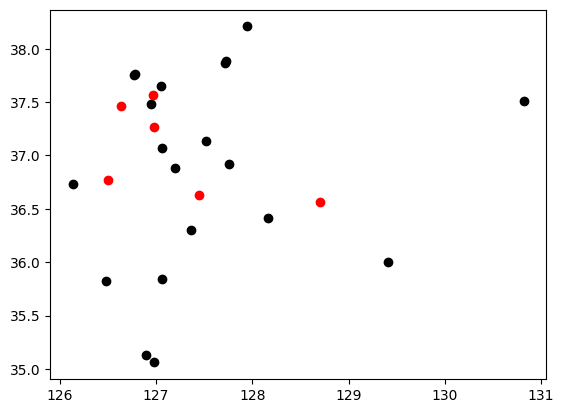

In [141]:
plt.plot(pollution["Long"].unique(),pollution["Lat"].unique(),"ok")
plt.plot(Weather["LONGITUDE"].unique(),Weather["LATITUDE"].unique(),"or")

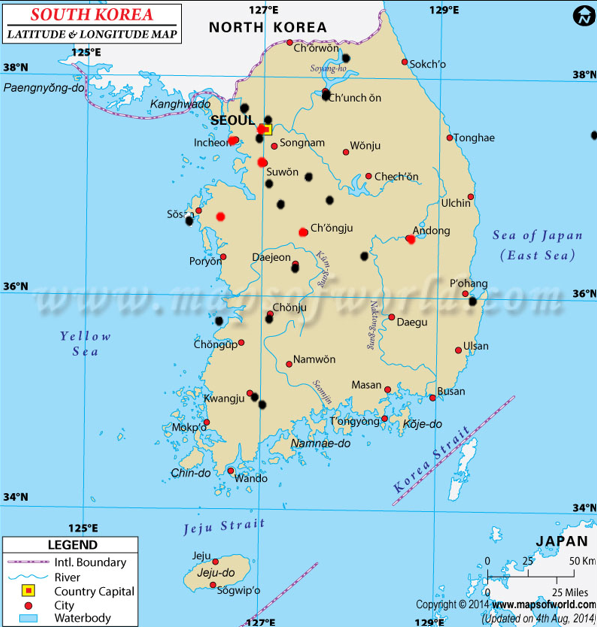

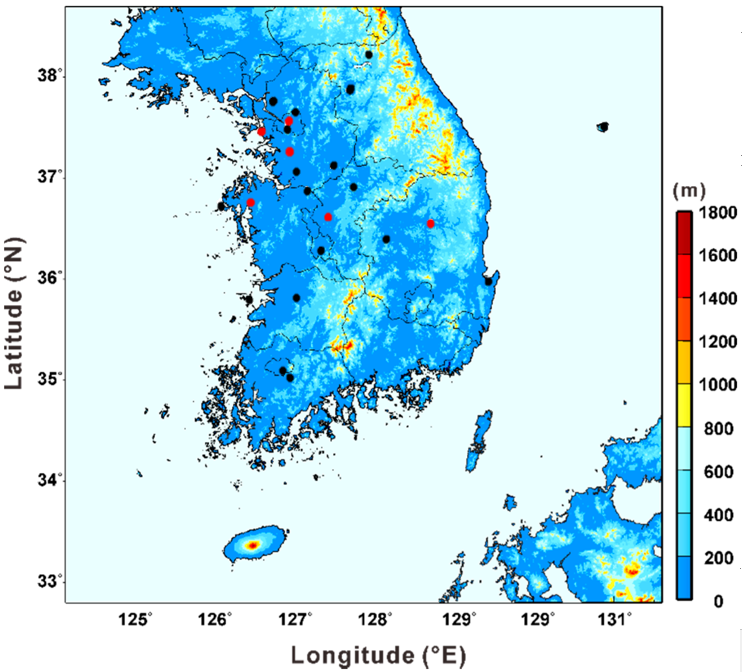

Con esta informacion, podemos descartar algunas ciudades, pero primero se ploteó un imshow, que muestra la distancia que tiene las ciudades en cada estacion, esto nos será ulti ala hora de elegir la ciudad "representante" de la estacion.

array([[ 3,  2, 12,  0,  4,  5,  6,  7,  8,  9, 10, 11,  1, 13, 14, 15,
        16, 17, 18, 19],
       [11, 17, 14,  3,  4,  5,  6,  7,  8,  9, 10,  0, 12, 13,  2, 15,
        16,  1, 18, 19],
       [ 3, 14,  9,  0,  4,  5,  6,  7,  8,  2, 10, 11, 12, 13,  1, 15,
        16, 17, 18, 19],
       [15,  1, 18,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  0,
        16, 17,  2, 19],
       [ 6, 17, 16,  3,  4,  5,  0,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         2,  1, 18, 19],
       [ 3,  9, 12,  0,  4,  5,  6,  7,  8,  1, 10, 11,  2, 13, 14, 15,
        16, 17, 18, 19]])

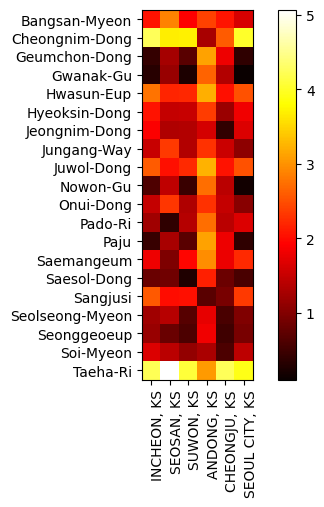

In [142]:
X=np.stack((pollution["Lat"].unique(),pollution["Long"].unique()),axis=1)
Y=np.stack((Weather["LATITUDE"].unique(),Weather["LONGITUDE"].unique()),axis=1)
fig, ax = plt.subplots()
dist_sq = np.sum(np.abs((X[:, np.newaxis, :] - Y[np.newaxis, :, :])) , axis=-1)
im=ax.imshow(dist_sq,cmap="hot");
fig.colorbar(im);

ax.set_xticks(np.arange(len(Weather["NAME"].unique())), labels=Weather["NAME"].unique())
ax.set_yticks(np.arange(len(pollution["City"].unique())), labels=pollution["City"].unique())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

nearest = np.argsort(dist_sq.T, axis=1)
nearest_partition = np.argpartition(dist_sq.T, 2, axis=1)
nearest_partition

Se llegó a la conclusion de que las estaciones "ANDONG','INCHEON'y'SEOSAN", no proporcionaban datos utiles para nuestro estudio, las razones fueron:

> ANDONG: Estaba cerca de un lago, lo que puede provocar variaciones en la temperatura, por ejemplo y ademas no tenia una ciudad suficientemente cercana al cual asociar los datos





> INCHEON: La estacion, es una ciudad costera, por lo que no proporciona datos acordes con las ciudades cercanas


> SEOSAN: La ciudad mas cercana corresponde con ser una ciudad costera como lo es la estacion, pero no es una ciudad metropolitana como lo es SEOSAN, es mas bien una villa, lo que no es comparable con una ciudad con mas de un millon de habitantes.








Se seleccionaron las ciudades mas cercanas (en el caso de SUWON, se escogio la segunda, ya que la ciudad gwanak, estaba mucho mas cerca de SEOUL).

<ipython-input-143-902de34d4d33>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Weather.drop(Weather[(Weather["NAME"]==i )].index,inplace=True)


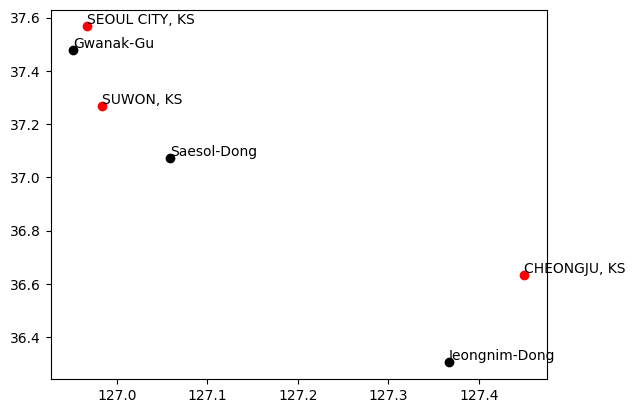

In [143]:
delate_p=np.delete(pollution["City"].unique(),[nearest_partition[[2,4,5],[1,0,0]]])
delate_w=['ANDONG, KS','INCHEON, KS','SEOSAN, KS']
for i in delate_p:
  pollution.drop(pollution[(pollution["City"]==i )].index,inplace=True)
for i in delate_w:
  Weather.drop(Weather[(Weather["NAME"]==i )].index,inplace=True)

plt.plot(pollution["Long"].unique(),pollution["Lat"].unique(),"ok")
plt.plot(Weather["LONGITUDE"].unique(),Weather["LATITUDE"].unique(),"or")
for i, label in enumerate(pollution["City"].unique()):
    plt.annotate(label, (pollution["Long"].unique()[i] , pollution["Lat"].unique()[i]+0.01))
for i, label in enumerate(Weather["NAME"].unique()):
    plt.annotate(label, (Weather["LONGITUDE"].unique()[i] , Weather["LATITUDE"].unique()[i]+0.01))



---
## Reorganizacion de datos.


Resumen: Los datos de "Weather"(varaibles ambientales) venian en un formato, tal que: "006000,1,9,9", lo que se tuvo que, averiguar a que correspondia ese formato y colocar el valor real.

In [144]:
for i in Weather["DATE"].index:
  Weather["DATE"][i]=Weather["DATE"][i][:10]
Weather

<ipython-input-144-f0ac15744013>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Weather["DATE"][i]=Weather["DATE"][i][:10]


STATION            NAME   LATITUDE   LONGITUDE  ELEVATION  \
53292   47119099999       SUWON, KS  37.266667  126.983333       35.0   
53293   47119099999       SUWON, KS  37.266667  126.983333       35.0   
53294   47119099999       SUWON, KS  37.266667  126.983333       35.0   
53295   47119099999       SUWON, KS  37.266667  126.983333       35.0   
53296   47119099999       SUWON, KS  37.266667  126.983333       35.0   
...             ...             ...        ...         ...        ...   
160041  47108099999  SEOUL CITY, KS  37.566667  126.966667       87.0   
160042  47108099999  SEOUL CITY, KS  37.566667  126.966667       87.0   
160043  47108099999  SEOUL CITY, KS  37.566667  126.966667       87.0   
160044  47108099999  SEOUL CITY, KS  37.566667  126.966667       87.0   
160045  47108099999  SEOUL CITY, KS  37.566667  126.966667       87.0   

              DATE SEA_LEVEL_PRESSURE      DEW     TEMP           VIS  \
53292   2014-01-01            10152,1  -0012,1  -0001,1  006000,1,9,9   
53293   2014-01-01            10135,1  -0060,1  +0086,1  015000,1,9,9   
53294   2014-01-01            10144,1  -0002,1  +0063,1  012000,1,9,9   
53295   2014-01-01            10158,1  +0008,1  +0051,1  009000,1,9,9   
53296   2014-01-01            10183,1  -0034,1  +0038,1  010000,1,9,9   
...            ...                ...      ...      ...           ...   
160041  2022-02-09            10232,1  -0082,1  -0017,1  020000,1,9,9   
160042  2022-02-09            10231,1  -0087,1  -0025,1  020000,1,9,9   
160043  2022-02-09            10230,1  -0082,1  -0025,1  020000,1,9,9   
160044  2022-02-09            10231,1  -0083,1  -0030,1  020000,1,9,9   
160045  2022-02-09            10237,1  -0084,1  -0032,1  020000,1,9,9   

                   WND  
53292   050,1,N,0005,1  
53293   250,1,N,0051,1  
53294   250,1,N,0036,1  
53295   270,1,N,0026,1  
53296   320,1,N,0031,1  
...                ...  
160041  297,1,N,0008,1  
160042  256,1,N,0017,1  
160043  268,1,N,0010,1  
160044  267,1,N,0011,1  
160045  262,1,N,0016,1  

[80063 rows x 11 columns]

Se puede apreciar varios valores separados por una coma en las columnas, en la documentacion, se expresa que algunos valores son parametros para decir si la muestra fue tomada con normalidad. Los valores que se tomaron en cuenta para el proyecto fueron solamente el valor empirico.

Tambien decir que en el caso del viento existian dos valores importantes, estos son el algulo con el que soplaba el viento con respecto al norte y la rapides.

La temperatura y el rocio esta en grados celsius con un factor de escala de 10, por lo que hay que dividir por ese factor

El siguiente codigo se logra hacer la limpieza:

In [145]:

Weather[" speed rate WND"]=Weather["VIS"]
Weather["angle nort WND"]=Weather["VIS"]
for i in Weather["DEW"].index:

    Weather["DEW"][i]=float(Weather["DEW"][i].split(",")[0])/10;

    Weather["TEMP"][i]=float(Weather["TEMP"][i].split(",")[0])/10;

    Weather["VIS"][i]=float(Weather["VIS"][i].split(",")[0]);
    Weather["SEA_LEVEL_PRESSURE"][i]=float(Weather["SEA_LEVEL_PRESSURE"][i].split(",")[0]);
    Weather["angle nort WND"][i]=float(Weather["WND"][i].split(",")[0]);
    Weather[" speed rate WND"][i]=float(Weather["WND"][i].split(",")[3]);
Weather=Weather.drop(['WND'], axis=1)
Weather


<ipython-input-145-7dc48e4c7ea2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Weather[" speed rate WND"]=Weather["VIS"]
<ipython-input-145-7dc48e4c7ea2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Weather["angle nort WND"]=Weather["VIS"]
<ipython-input-145-7dc48e4c7ea2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

STATION            NAME   LATITUDE   LONGITUDE  ELEVATION  \
53292   47119099999       SUWON, KS  37.266667  126.983333       35.0   
53293   47119099999       SUWON, KS  37.266667  126.983333       35.0   
53294   47119099999       SUWON, KS  37.266667  126.983333       35.0   
53295   47119099999       SUWON, KS  37.266667  126.983333       35.0   
53296   47119099999       SUWON, KS  37.266667  126.983333       35.0   
...             ...             ...        ...         ...        ...   
160041  47108099999  SEOUL CITY, KS  37.566667  126.966667       87.0   
160042  47108099999  SEOUL CITY, KS  37.566667  126.966667       87.0   
160043  47108099999  SEOUL CITY, KS  37.566667  126.966667       87.0   
160044  47108099999  SEOUL CITY, KS  37.566667  126.966667       87.0   
160045  47108099999  SEOUL CITY, KS  37.566667  126.966667       87.0   

              DATE SEA_LEVEL_PRESSURE  DEW TEMP      VIS  speed rate WND  \
53292   2014-01-01            10152.0 -1.2 -0.1   6000.0             5.0   
53293   2014-01-01            10135.0 -6.0  8.6  15000.0            51.0   
53294   2014-01-01            10144.0 -0.2  6.3  12000.0            36.0   
53295   2014-01-01            10158.0  0.8  5.1   9000.0            26.0   
53296   2014-01-01            10183.0 -3.4  3.8  10000.0            31.0   
...            ...                ...  ...  ...      ...             ...   
160041  2022-02-09            10232.0 -8.2 -1.7  20000.0             8.0   
160042  2022-02-09            10231.0 -8.7 -2.5  20000.0            17.0   
160043  2022-02-09            10230.0 -8.2 -2.5  20000.0            10.0   
160044  2022-02-09            10231.0 -8.3 -3.0  20000.0            11.0   
160045  2022-02-09            10237.0 -8.4 -3.2  20000.0            16.0   

       angle nort WND  
53292            50.0  
53293           250.0  
53294           250.0  
53295           270.0  
53296           320.0  
...               ...  
160041          297.0  
160042          256.0  
160043          268.0  
160044          267.0  
160045          262.0  

[80063 rows x 12 columns]

Ahora, segun la documentacion, existen casos en los que la muestra sufrio errores o no se midió, por lo que se le asignaron valores característicos.

In [146]:
Weather.drop(Weather[(Weather["SEA_LEVEL_PRESSURE"]==99999 )].index,inplace=True)
Weather.drop(Weather[(Weather["DEW"]>=999 )].index,inplace=True)
Weather.drop(Weather[(Weather["TEMP"]>=999 )].index,inplace=True)
Weather.drop(Weather[(Weather["VIS"]==999999 )].index,inplace=True)
Weather.drop(Weather[(Weather["angle nort WND"]==999 )].index,inplace=True)
Weather.drop(Weather[(Weather[" speed rate WND"]==9999 )].index,inplace=True)
Weather

STATION            NAME   LATITUDE   LONGITUDE  ELEVATION  \
53292   47119099999       SUWON, KS  37.266667  126.983333       35.0   
53293   47119099999       SUWON, KS  37.266667  126.983333       35.0   
53294   47119099999       SUWON, KS  37.266667  126.983333       35.0   
53295   47119099999       SUWON, KS  37.266667  126.983333       35.0   
53296   47119099999       SUWON, KS  37.266667  126.983333       35.0   
...             ...             ...        ...         ...        ...   
160041  47108099999  SEOUL CITY, KS  37.566667  126.966667       87.0   
160042  47108099999  SEOUL CITY, KS  37.566667  126.966667       87.0   
160043  47108099999  SEOUL CITY, KS  37.566667  126.966667       87.0   
160044  47108099999  SEOUL CITY, KS  37.566667  126.966667       87.0   
160045  47108099999  SEOUL CITY, KS  37.566667  126.966667       87.0   

              DATE SEA_LEVEL_PRESSURE  DEW TEMP      VIS  speed rate WND  \
53292   2014-01-01            10152.0 -1.2 -0.1   6000.0             5.0   
53293   2014-01-01            10135.0 -6.0  8.6  15000.0            51.0   
53294   2014-01-01            10144.0 -0.2  6.3  12000.0            36.0   
53295   2014-01-01            10158.0  0.8  5.1   9000.0            26.0   
53296   2014-01-01            10183.0 -3.4  3.8  10000.0            31.0   
...            ...                ...  ...  ...      ...             ...   
160041  2022-02-09            10232.0 -8.2 -1.7  20000.0             8.0   
160042  2022-02-09            10231.0 -8.7 -2.5  20000.0            17.0   
160043  2022-02-09            10230.0 -8.2 -2.5  20000.0            10.0   
160044  2022-02-09            10231.0 -8.3 -3.0  20000.0            11.0   
160045  2022-02-09            10237.0 -8.4 -3.2  20000.0            16.0   

       angle nort WND  
53292            50.0  
53293           250.0  
53294           250.0  
53295           270.0  
53296           320.0  
...               ...  
160041          297.0  
160042          256.0  
160043          268.0  
160044          267.0  
160045          262.0  

[77786 rows x 12 columns]

Se cambiaron los indices.

In [147]:
Weather=Weather.set_index(['NAME',"DATE"])
Weather

STATION   LATITUDE   LONGITUDE  ELEVATION  \
NAME           DATE                                                        
SUWON, KS      2014-01-01  47119099999  37.266667  126.983333       35.0   
               2014-01-01  47119099999  37.266667  126.983333       35.0   
               2014-01-01  47119099999  37.266667  126.983333       35.0   
               2014-01-01  47119099999  37.266667  126.983333       35.0   
               2014-01-01  47119099999  37.266667  126.983333       35.0   
...                                ...        ...         ...        ...   
SEOUL CITY, KS 2022-02-09  47108099999  37.566667  126.966667       87.0   
               2022-02-09  47108099999  37.566667  126.966667       87.0   
               2022-02-09  47108099999  37.566667  126.966667       87.0   
               2022-02-09  47108099999  37.566667  126.966667       87.0   
               2022-02-09  47108099999  37.566667  126.966667       87.0   

                          SEA_LEVEL_PRESSURE  DEW TEMP      VIS  \
NAME           DATE                                               
SUWON, KS      2014-01-01            10152.0 -1.2 -0.1   6000.0   
               2014-01-01            10135.0 -6.0  8.6  15000.0   
               2014-01-01            10144.0 -0.2  6.3  12000.0   
               2014-01-01            10158.0  0.8  5.1   9000.0   
               2014-01-01            10183.0 -3.4  3.8  10000.0   
...                                      ...  ...  ...      ...   
SEOUL CITY, KS 2022-02-09            10232.0 -8.2 -1.7  20000.0   
               2022-02-09            10231.0 -8.7 -2.5  20000.0   
               2022-02-09            10230.0 -8.2 -2.5  20000.0   
               2022-02-09            10231.0 -8.3 -3.0  20000.0   
               2022-02-09            10237.0 -8.4 -3.2  20000.0   

                           speed rate WND angle nort WND  
NAME           DATE                                       
SUWON, KS      2014-01-01             5.0           50.0  
               2014-01-01            51.0          250.0  
               2014-01-01            36.0          250.0  
               2014-01-01            26.0          270.0  
               2014-01-01            31.0          320.0  
...                                   ...            ...  
SEOUL CITY, KS 2022-02-09             8.0          297.0  
               2022-02-09            17.0          256.0  
               2022-02-09            10.0          268.0  
               2022-02-09            11.0          267.0  
               2022-02-09            16.0          262.0  

[77786 rows x 10 columns]


---
## Construccion de los datos finales.


Resumen:Se creó otro datasets, donde se alinean los valores de las estaciones y su ciudad correspondiente.

Se eligieron las siguientes columnas, cada varaible ambiental se le tomo su valor minimo, maximo y promedio, ya que, se tienen valores distinto a cada hora del dia, a excepcion de la presion, ya que, su valor no varia mucho se eligió el promedio del dia.

In [148]:
columnas=["Station","date","dew_min","Temp_min","Vis_min","wind_sr_min","wind_an_min","dew_max","Temp_max","Vis_max","wind_sr_max","wind_an_max","pressure_mean","dew_mean","Temp_mean","Vis_mean","wind_sr_mean","wind_an_mean"]


In [149]:

Weather_update=pd.DataFrame(columns=columnas)
Weather_update


Empty DataFrame
Columns: [Station, date, dew_min, Temp_min, Vis_min, wind_sr_min, wind_an_min, dew_max, Temp_max, Vis_max, wind_sr_max, wind_an_max, pressure_mean, dew_mean, Temp_mean, Vis_mean, wind_sr_mean, wind_an_mean]
Index: []

In [150]:
for i in ['SUWON, KS', 'CHEONGJU, KS', 'SEOUL CITY, KS']:
  for w in Weather.loc[i].index.unique():
    temp=np.concatenate(([i],[w],Weather.loc[i,w].min()[5:10].to_numpy(),Weather.loc[i,w].max()[5:10].to_numpy(),Weather.loc[i,w].mean()[4:10].to_numpy()),axis=0);
    temp_df=pd.DataFrame((temp,),columns=columnas)
    Weather_update=Weather_update.append(temp_df,ignore_index=True)

Se han truncado las últimas 5000 líneas del flujo de salida.
<ipython-input-150-9c0619397661>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  temp=np.concatenate(([i],[w],Weather.loc[i,w].min()[5:10].to_numpy(),Weather.loc[i,w].max()[5:10].to_numpy(),Weather.loc[i,w].mean()[4:10].to_numpy()),axis=0);
<ipython-input-150-9c0619397661>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  temp=np.concatenate(([i],[w],Weather.loc[i,w].min()[5:10].to_numpy(),Weather.loc[i,w].max()[5:10].to_numpy(),Weather.loc[i,w].mean()[4:10].to_numpy()),axis=0);
<ipython-input-150-9c0619397661>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  temp=np.concatenate(([i],[w],Weather.loc[i,w].min()[5:10].to_numpy(),Weather.loc[i,w].max()[5:10].to_numpy(),Weather.loc[i,w].mean()[4:10].to_numpy()),axis=0);
<ipython-input-150-9c0619397661>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

In [153]:
Weather_update

Station        date  dew_min  Temp_min  Vis_min  wind_sr_min  \
0          SUWON, KS  2014-01-01     -8.2      -0.1   6000.0          5.0   
1          SUWON, KS  2014-01-02    -12.1      -2.1  12000.0          5.0   
2          SUWON, KS  2014-01-03     -9.5      -2.2   6000.0          5.0   
3          SUWON, KS  2014-01-04     -8.9      -4.7   6000.0          5.0   
4          SUWON, KS  2014-01-05    -10.0      -5.2   5000.0          5.0   
...              ...         ...      ...       ...      ...          ...   
8878  SEOUL CITY, KS  2022-02-05    -17.8      -8.7  20000.0          2.0   
8879  SEOUL CITY, KS  2022-02-06    -13.7      -7.0  20000.0         10.0   
8880  SEOUL CITY, KS  2022-02-07    -13.4      -5.5  20000.0          2.0   
8881  SEOUL CITY, KS  2022-02-08    -12.2      -4.2  20000.0          5.0   
8882  SEOUL CITY, KS  2022-02-09    -10.4      -3.2  20000.0          8.0   

      wind_an_min  dew_max  Temp_max  Vis_max  wind_sr_max  wind_an_max  \
0            50.0      0.8       8.6  15000.0         51.0        340.0   
1           200.0     -5.6       6.8  20000.0         21.0        360.0   
2           160.0      1.4       8.2  20000.0         26.0        320.0   
3           200.0     -5.9       3.5  18000.0         31.0        360.0   
4           200.0     -4.9       3.7  20000.0         31.0        360.0   
...           ...      ...       ...      ...          ...          ...   
8878         18.0    -12.5      -2.5  20000.0         58.0        338.0   
8879         41.0    -11.1       1.2  20000.0         52.0        314.0   
8880          9.0     -8.6       2.0  20000.0         40.0        345.0   
8881          2.0     -6.0       5.2  20000.0         33.0        359.0   
8882         33.0     -6.5       7.2  20000.0         34.0        297.0   

      pressure_mean   dew_mean  Temp_mean      Vis_mean  wind_sr_mean  \
0      10167.857143  -3.771429   3.614286  11571.428571     26.428571   
1      10215.200000  -8.840000   2.720000  16800.000000     12.200000   
2      10174.571429  -4.557143   3.214286  12857.142857     17.571429   
3      10210.200000  -6.820000  -1.000000  12400.000000     13.200000   
4      10255.625000  -7.775000  -0.887500  12375.000000     12.625000   
...             ...        ...        ...           ...           ...   
8878   10271.958333 -14.854167  -6.220833  20000.000000     25.958333   
8879   10282.833333 -12.658333  -3.416667  20000.000000     26.583333   
8880   10277.916667 -10.562500  -1.537500  20000.000000     16.125000   
8881   10276.041667  -8.420833  -0.037500  20000.000000     20.666667   
8882   10241.916667  -8.562500   1.450000  20000.000000     17.375000   

      wind_an_mean  
0       252.857143  
1       280.000000  
2       280.000000  
3       280.000000  
4       270.000000  
...            ...  
8878    265.083333  
8879    270.041667  
8880    207.958333  
8881    198.000000  
8882    224.291667  

[8883 rows x 18 columns]

Se ignoran algunas columnas  de las ciudades del data set "pollution", que no proporcionaban informacion y se agurega la columna "Station" donde se asocia cada ciudad con su estacion, para poder hacer el merge con las "Weather".

In [154]:
pollution_update=pollution[['City','date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co']]
pollution_update["Station"]=None

<ipython-input-154-056c449d7f0e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollution_update["Station"]=None


In [155]:
for  i in pollution_update.index:
  if pollution_update["City"][i] =='Jeongnim-Dong':
    pollution_update["Station"].loc[i]="CHEONGJU, KS"

  elif pollution_update["City"][i] =='Gwanak-Gu':
    pollution_update["Station"].loc[i]="SEOUL CITY, KS"

  elif pollution_update["City"][i] =='Saesol-Dong':
    pollution_update["Station"].loc[i]="SUWON, KS"
Weather_update["date"]=pd.to_datetime(Weather_update["date"])
pollution_update["date"]=pd.to_datetime(pollution_update["date"])

<ipython-input-155-12f78c964511>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollution_update["Station"].loc[i]="SEOUL CITY, KS"
<ipython-input-155-12f78c964511>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollution_update["Station"].loc[i]="CHEONGJU, KS"
<ipython-input-155-12f78c964511>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollution_update["Station"].loc[i]="SUWON, KS"
<ipython-input-155-12f78c964511>:11: Setting

In [156]:
pollution_update

City       date  pm25  pm10  o3  no2  so2  co         Station
6555     Gwanak-Gu 2022-02-01    91    26  22   17    3   4  SEOUL CITY, KS
6556     Gwanak-Gu 2022-02-02    68    18  23   21    4   4  SEOUL CITY, KS
6557     Gwanak-Gu 2022-02-03    47    17  22   17    4   4  SEOUL CITY, KS
6558     Gwanak-Gu 2022-02-04    42    21  20   13    3   3  SEOUL CITY, KS
6559     Gwanak-Gu 2022-02-05    34    18  22   21    4   4  SEOUL CITY, KS
...            ...        ...   ...   ...  ..  ...  ...  ..             ...
28163  Saesol-Dong 2020-06-30    19    22  39    8    6   5       SUWON, KS
28164  Saesol-Dong 2022-01-31     0    37  35    2    2   6       SUWON, KS
28165  Saesol-Dong 2022-01-24     0    25  29   14    5   5       SUWON, KS
28166  Saesol-Dong 2021-01-03     0    41  11   35    5   9       SUWON, KS
28167  Saesol-Dong 2020-06-21     0    42  90   12    5   5       SUWON, KS

[6366 rows x 9 columns]

In [157]:
Weather_update

Station       date  dew_min  Temp_min  Vis_min  wind_sr_min  \
0          SUWON, KS 2014-01-01     -8.2      -0.1   6000.0          5.0   
1          SUWON, KS 2014-01-02    -12.1      -2.1  12000.0          5.0   
2          SUWON, KS 2014-01-03     -9.5      -2.2   6000.0          5.0   
3          SUWON, KS 2014-01-04     -8.9      -4.7   6000.0          5.0   
4          SUWON, KS 2014-01-05    -10.0      -5.2   5000.0          5.0   
...              ...        ...      ...       ...      ...          ...   
8878  SEOUL CITY, KS 2022-02-05    -17.8      -8.7  20000.0          2.0   
8879  SEOUL CITY, KS 2022-02-06    -13.7      -7.0  20000.0         10.0   
8880  SEOUL CITY, KS 2022-02-07    -13.4      -5.5  20000.0          2.0   
8881  SEOUL CITY, KS 2022-02-08    -12.2      -4.2  20000.0          5.0   
8882  SEOUL CITY, KS 2022-02-09    -10.4      -3.2  20000.0          8.0   

      wind_an_min  dew_max  Temp_max  Vis_max  wind_sr_max  wind_an_max  \
0            50.0      0.8       8.6  15000.0         51.0        340.0   
1           200.0     -5.6       6.8  20000.0         21.0        360.0   
2           160.0      1.4       8.2  20000.0         26.0        320.0   
3           200.0     -5.9       3.5  18000.0         31.0        360.0   
4           200.0     -4.9       3.7  20000.0         31.0        360.0   
...           ...      ...       ...      ...          ...          ...   
8878         18.0    -12.5      -2.5  20000.0         58.0        338.0   
8879         41.0    -11.1       1.2  20000.0         52.0        314.0   
8880          9.0     -8.6       2.0  20000.0         40.0        345.0   
8881          2.0     -6.0       5.2  20000.0         33.0        359.0   
8882         33.0     -6.5       7.2  20000.0         34.0        297.0   

      pressure_mean   dew_mean  Temp_mean      Vis_mean  wind_sr_mean  \
0      10167.857143  -3.771429   3.614286  11571.428571     26.428571   
1      10215.200000  -8.840000   2.720000  16800.000000     12.200000   
2      10174.571429  -4.557143   3.214286  12857.142857     17.571429   
3      10210.200000  -6.820000  -1.000000  12400.000000     13.200000   
4      10255.625000  -7.775000  -0.887500  12375.000000     12.625000   
...             ...        ...        ...           ...           ...   
8878   10271.958333 -14.854167  -6.220833  20000.000000     25.958333   
8879   10282.833333 -12.658333  -3.416667  20000.000000     26.583333   
8880   10277.916667 -10.562500  -1.537500  20000.000000     16.125000   
8881   10276.041667  -8.420833  -0.037500  20000.000000     20.666667   
8882   10241.916667  -8.562500   1.450000  20000.000000     17.375000   

      wind_an_mean  
0       252.857143  
1       280.000000  
2       280.000000  
3       280.000000  
4       270.000000  
...            ...  
8878    265.083333  
8879    270.041667  
8880    207.958333  
8881    198.000000  
8882    224.291667  

[8883 rows x 18 columns]

### Datos finales:

El merge de Weather con pollution, proporcionan los datos finales que se usaran para el analisis.

In [158]:
data=pd.merge(Weather_update,pollution_update )


Se escogieron datos de 2020 en adelante, con menos datos mejora el timepo de ejecución.

In [160]:
data['Year'] = data['date'].dt.year
data=data[data["Year"]>=2020]
data

Station       date  dew_min  Temp_min  Vis_min  wind_sr_min  \
0          SUWON, KS 2020-06-21     17.6      19.7   6000.0          5.0   
1          SUWON, KS 2020-06-22     17.3      21.0   6000.0         10.0   
2          SUWON, KS 2020-06-23     17.0      24.0  13000.0          5.0   
3          SUWON, KS 2020-06-24     17.9      21.0   3300.0         10.0   
4          SUWON, KS 2020-06-25     18.9      19.0   4100.0         15.0   
...              ...        ...      ...       ...      ...          ...   
6323  SEOUL CITY, KS 2022-02-05    -17.8      -8.7  20000.0          2.0   
6324  SEOUL CITY, KS 2022-02-06    -13.7      -7.0  20000.0         10.0   
6325  SEOUL CITY, KS 2022-02-07    -13.4      -5.5  20000.0          2.0   
6326  SEOUL CITY, KS 2022-02-08    -12.2      -4.2  20000.0          5.0   
6327  SEOUL CITY, KS 2022-02-09    -10.4      -3.2  20000.0          8.0   

      wind_an_min  dew_max  Temp_max  Vis_max  ...  wind_sr_mean  \
0           140.0     19.4      30.2  19000.0  ...     18.857143   
1           200.0     20.7      33.6  20000.0  ...     15.750000   
2            70.0     19.4      29.4  20000.0  ...     16.500000   
3           110.0     21.4      23.7  20000.0  ...     25.250000   
4           160.0     21.4      22.7  18000.0  ...     24.125000   
...           ...      ...       ...      ...  ...           ...   
6323         18.0    -12.5      -2.5  20000.0  ...     25.958333   
6324         41.0    -11.1       1.2  20000.0  ...     26.583333   
6325          9.0     -8.6       2.0  20000.0  ...     16.125000   
6326          2.0     -6.0       5.2  20000.0  ...     20.666667   
6327         33.0     -6.5       7.2  20000.0  ...     17.375000   

      wind_an_mean         City  pm25  pm10  o3  no2  so2 co  Year  
0       245.714286  Saesol-Dong     0    42  90   12    5  5  2020  
1       235.000000  Saesol-Dong    77    32  59   13    5  5  2020  
2       231.250000  Saesol-Dong    71    29  29   15    5  5  2020  
3       141.250000  Saesol-Dong    70    15  29    6    4  5  2020  
4       225.000000  Saesol-Dong    37    16  50    3    4  5  2020  
...            ...          ...   ...   ...  ..  ...  ... ..   ...  
6323    265.083333    Gwanak-Gu    34    18  22   21    4  4  2022  
6324    270.041667    Gwanak-Gu    38    21  18   29    4  5  2022  
6325    207.958333    Gwanak-Gu    49    22  20   38    4  6  2022  
6326    198.000000    Gwanak-Gu    56    30  12   50    4  8  2022  
6327    224.291667    Gwanak-Gu    73    40  30   38    4  7  2022  

[2131 rows x 26 columns]

In [161]:
data["Station"].value_counts()

SEOUL CITY, KS    769
CHEONGJU, KS      768
SUWON, KS         594
Name: Station, dtype: int64



---
## Graficos y analisis


Cantidad de datos por ciudad

In [162]:
data["Station"].value_counts()

SEOUL CITY, KS    769
CHEONGJU, KS      768
SUWON, KS         594
Name: Station, dtype: int64

Plot de pm2.5 de cada ciudad en el tiempo

In [163]:
data=data.set_index(['Station'])

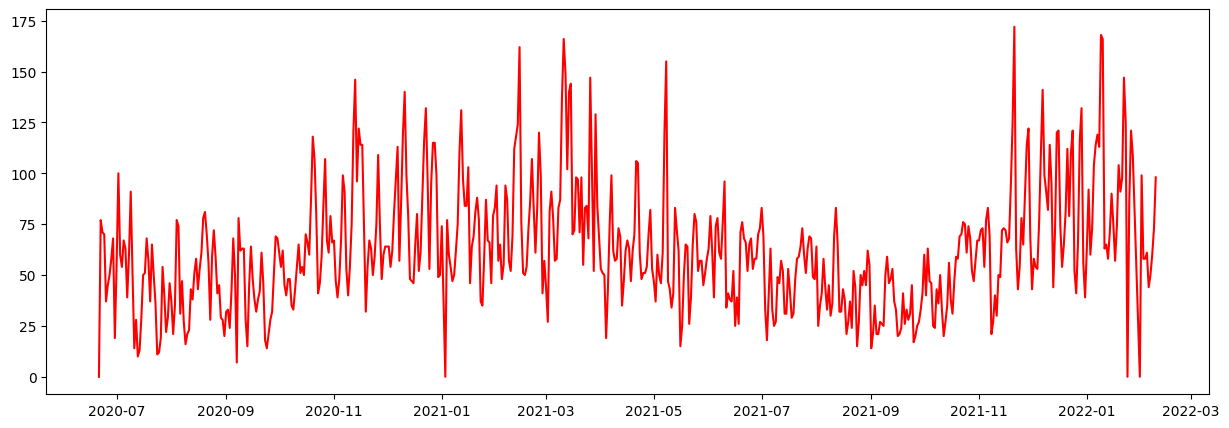

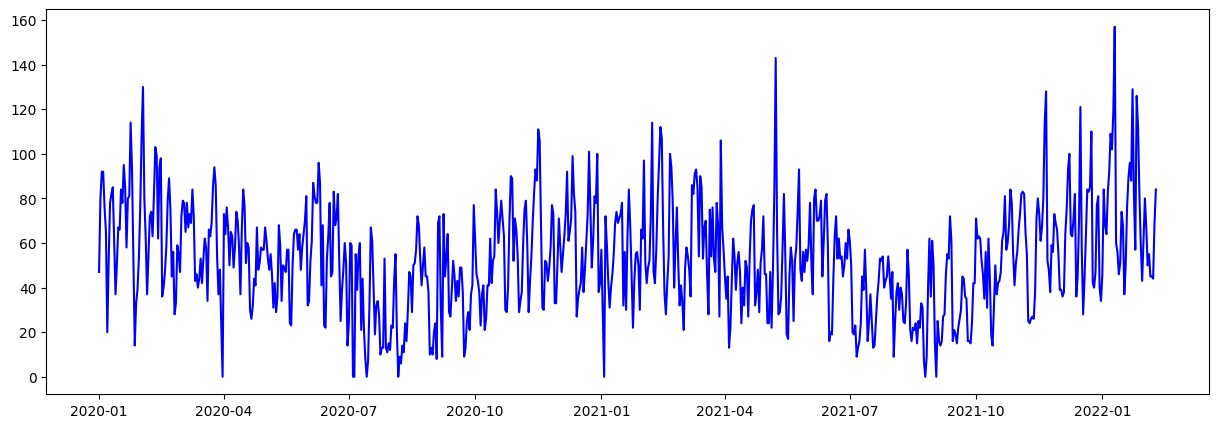

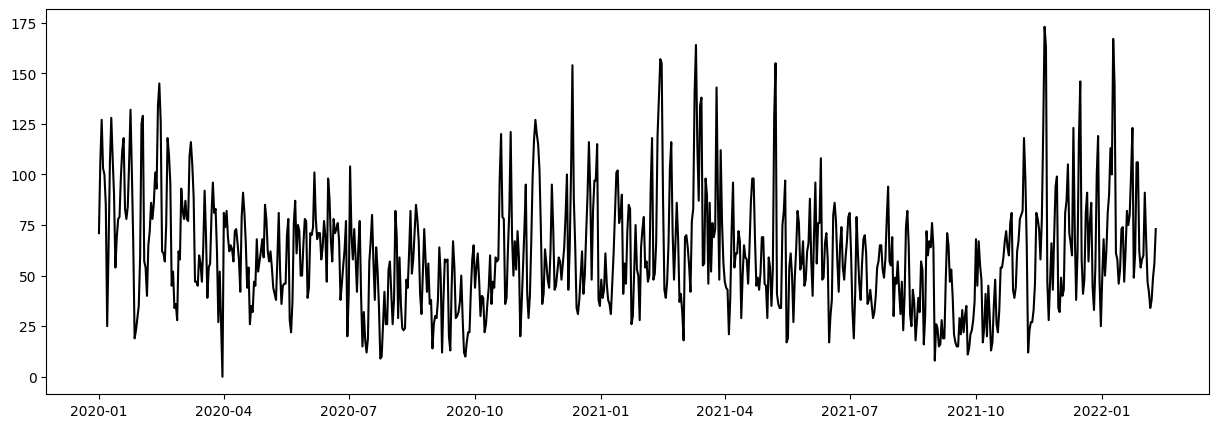

In [164]:
fig = plt.figure(figsize=(15,5))
plt.plot(data.loc["SUWON, KS"]["date"],data.loc["SUWON, KS"]["pm25"],"-r")
plt.show()
fig = plt.figure(figsize=(15,5))
plt.plot(data.loc["CHEONGJU, KS"]["date"],data.loc["CHEONGJU, KS"]["pm25"],"-b")
plt.show()
fig = plt.figure(figsize=(15,5))
plt.plot(data.loc["SEOUL CITY, KS"]["date"],data.loc["SEOUL CITY, KS"]["pm25"],"-k")
plt.show()

Correlacion en la ciudad de Seoul

In [165]:
data.groupby(["Station"]).corr().loc["SEOUL CITY, KS"]

<ipython-input-165-127f4c12f1a7>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.corr is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby(["Station"]).corr().loc["SEOUL CITY, KS"]


dew_min  Temp_min   Vis_min  wind_sr_min  wind_an_min  \
dew_min        1.000000  0.963688 -0.209092    -0.021841    -0.165150   
Temp_min       0.963688  1.000000 -0.125853    -0.010043    -0.163487   
Vis_min       -0.209092 -0.125853  1.000000    -0.009649    -0.106555   
wind_sr_min   -0.021841 -0.010043 -0.009649     1.000000     0.261582   
wind_an_min   -0.165150 -0.163487 -0.106555     0.261582     1.000000   
dew_max        0.961597  0.949276 -0.281903     0.015815    -0.145691   
Temp_max       0.922326  0.973054 -0.092393    -0.020502    -0.191463   
Vis_max       -0.045530  0.009404  0.384255     0.039248    -0.013847   
wind_sr_max   -0.175649 -0.153337 -0.035511     0.331059     0.292661   
wind_an_max   -0.261975 -0.255421 -0.019028    -0.422147     0.129954   
pressure_mean -0.772782 -0.777503  0.299198    -0.101804    -0.019947   
dew_mean       0.989903  0.965638 -0.245162    -0.008861    -0.165874   
Temp_mean      0.950873  0.992594 -0.113304    -0.011547    -0.178866   
Vis_mean      -0.178332 -0.095837  0.816623     0.022021    -0.065640   
wind_sr_mean  -0.174866 -0.146802 -0.016753     0.652180     0.381386   
wind_an_mean  -0.370558 -0.363492 -0.103318    -0.106778     0.569398   
pm25          -0.200592 -0.227591 -0.416460    -0.141649     0.000163   
pm10          -0.169116 -0.166402 -0.172438    -0.113783     0.004317   
o3             0.579292  0.619727 -0.065836    -0.099904    -0.032400   
no2           -0.466698 -0.481276  0.116534    -0.300029    -0.244629   
so2           -0.327238 -0.335869  0.033373    -0.267398    -0.016177   
co            -0.419812 -0.473857 -0.026798    -0.287548    -0.226776   
Year          -0.133169 -0.181178  0.221196    -0.138917    -0.096839   

                dew_max  Temp_max   Vis_max  wind_sr_max  wind_an_max  ...  \
dew_min        0.961597  0.922326 -0.045530    -0.175649    -0.261975  ...   
Temp_min       0.949276  0.973054  0.009404    -0.153337    -0.255421  ...   
Vis_min       -0.281903 -0.092393  0.384255    -0.035511    -0.019028  ...   
wind_sr_min    0.015815 -0.020502  0.039248     0.331059    -0.422147  ...   
wind_an_min   -0.145691 -0.191463 -0.013847     0.292661     0.129954  ...   
dew_max        1.000000  0.927596 -0.006076    -0.093630    -0.255097  ...   
Temp_max       0.927596  1.000000  0.042427    -0.133148    -0.227667  ...   
Vis_max       -0.006076  0.042427  1.000000     0.130106    -0.097542  ...   
wind_sr_max   -0.093630 -0.133148  0.130106     1.000000    -0.079364  ...   
wind_an_max   -0.255097 -0.227667 -0.097542    -0.079364     1.000000  ...   
pressure_mean -0.803867 -0.741974 -0.008933    -0.124747     0.206269  ...   
dew_mean       0.986425  0.931223 -0.031979    -0.154548    -0.260791  ...   
Temp_mean      0.950635  0.991041  0.030093    -0.143342    -0.249981  ...   
Vis_mean      -0.190525 -0.044750  0.713084     0.096030    -0.046641  ...   
wind_sr_mean  -0.088921 -0.142480  0.137494     0.818223    -0.289203  ...   
wind_an_mean  -0.345309 -0.349645 -0.095436     0.243489     0.674140  ...   
pm25          -0.189319 -0.172753 -0.423584    -0.182424     0.213088  ...   
pm10          -0.183369 -0.143409 -0.223622    -0.117234     0.193570  ...   
o3             0.577597  0.645161  0.053830    -0.038905     0.021073  ...   
no2           -0.533095 -0.450710 -0.163233    -0.361525     0.224561  ...   
so2           -0.372675 -0.310762 -0.136672    -0.269099     0.294890  ...   
co            -0.485164 -0.453940 -0.271388    -0.358903     0.213941  ...   
Year          -0.140312 -0.160766  0.248672     0.012448     0.003035  ...   

               Vis_mean  wind_sr_mean  wind_an_mean      pm25      pm10  \
dew_min       -0.178332     -0.174866     -0.370558 -0.200592 -0.169116   
Temp_min      -0.095837     -0.146802     -0.363492 -0.227591 -0.166402   
Vis_min        0.816623     -0.016753     -0.103318 -0.416460 -0.172438   
wind_sr_min    0.022021      0.652180     -0.106778 -0.141649 -0.113783   
wind_an_min   -

Mapa de calor de la correlacion entre los datos de la ciudad Seoul.

<ipython-input-166-f04e1d68f492>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  .corr(),center = 0.0,linewidths = 0.5,


<Axes: >

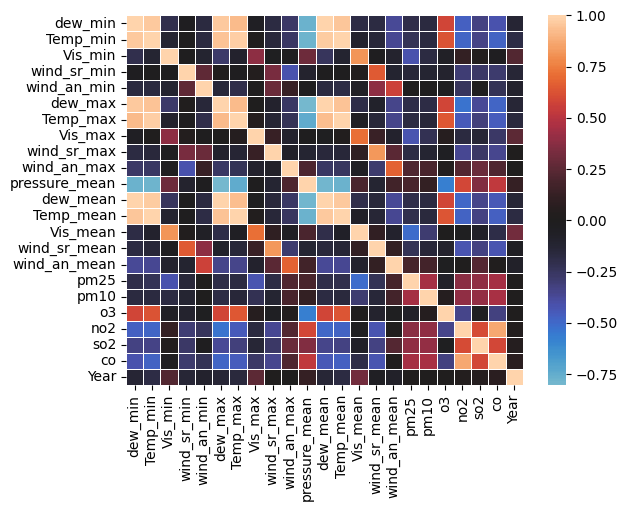

In [166]:
heatmap(data.loc["SEOUL CITY, KS"]
.corr(),center = 0.0,linewidths = 0.5,
            linecolor = "white")


In [167]:
data.columns.values

array(['date', 'dew_min', 'Temp_min', 'Vis_min', 'wind_sr_min',
       'wind_an_min', 'dew_max', 'Temp_max', 'Vis_max', 'wind_sr_max',
       'wind_an_max', 'pressure_mean', 'dew_mean', 'Temp_mean',
       'Vis_mean', 'wind_sr_mean', 'wind_an_mean', 'City', 'pm25', 'pm10',
       'o3', 'no2', 'so2', 'co', 'Year'], dtype=object)

Cantidad de valores repetidos y su porcentaje, en todo el dataset.

In [168]:
df_frec=pd.DataFrame(columns=["Valor","Conteo","Porcentaje con el total"],index=data.columns.values)
for i in data.columns.values:
  maxi=data[i].value_counts().max()
  idmaxi=data[i].value_counts().idxmax()
  porcentaje=maxi/data.shape[0]*100
  df_frec.loc[i]=[idmaxi,maxi,round(porcentaje,2)]
df_frec

Valor Conteo Porcentaje con el total
date           2020-06-21 00:00:00      3                    0.14
dew_min                       18.1     17                     0.8
Temp_min                      20.7     23                    1.08
Vis_min                    20000.0    244                   11.45
wind_sr_min                    5.0    488                    22.9
wind_an_min                   20.0    126                    5.91
dew_max                       19.4     18                    0.84
Temp_max                      17.7     28                    1.31
Vis_max                    20000.0   1007                   47.25
wind_sr_max                   25.0    121                    5.68
wind_an_max                  360.0    644                   30.22
pressure_mean              10191.0      6                    0.28
dew_mean                   19.1125      4                    0.19
Temp_mean                   2.1625      4                    0.19
Vis_mean                   20000.0    237                   11.12
wind_sr_mean                 20.25     23                    1.08
wind_an_mean                 240.0     10                    0.47
City                     Gwanak-Gu    769                   36.09
pm25                            57     49                     2.3
pm10                            22     82                    3.85
o3                              29     80                    3.75
no2                             11    111                    5.21
so2                              4    560                   26.28
co                               4    613                   28.77
Year                          2021   1090                   51.15

### Target:

Los valores target ("pm2.5") se pasaron a valores discretos, con el fin de ocupar los modelos de clasificacion. Los valores nuevos son "Emergencia", "Premergencia", "Alerta", "Regular", "Bueno" (estos segun los criterios de chile).

In [169]:
target=[]
for i in list(range(data.shape[0])):
  temp=data.iloc[i]["pm25"]
  if temp>=170:
    target.append("Emergencia")
  elif temp<170 and temp>=110:
    target.append("Premergencia")
  elif temp<110 and temp>=80:
    target.append("Alerta")
  elif temp<80 and temp>=50:
    target.append("Regular")
  elif temp<50 and temp>=0.0:
    target.append("Bueno")


In [170]:
data["pm25_discreto"]=target

Se experimentaron nuevas relaciones entres las columnas para mejorar el modelo.

In [171]:
data["Relacion1"]=data["dew_mean"]/data["Vis_mean"]
data["Relacion2"]=data["dew_mean"]/data["pressure_mean"]
data["Relacion3"]=data["Vis_mean"]/data["pressure_mean"]

PairPlot de los datos, donde los colores hacen referencia al valor discreto de "pm25"

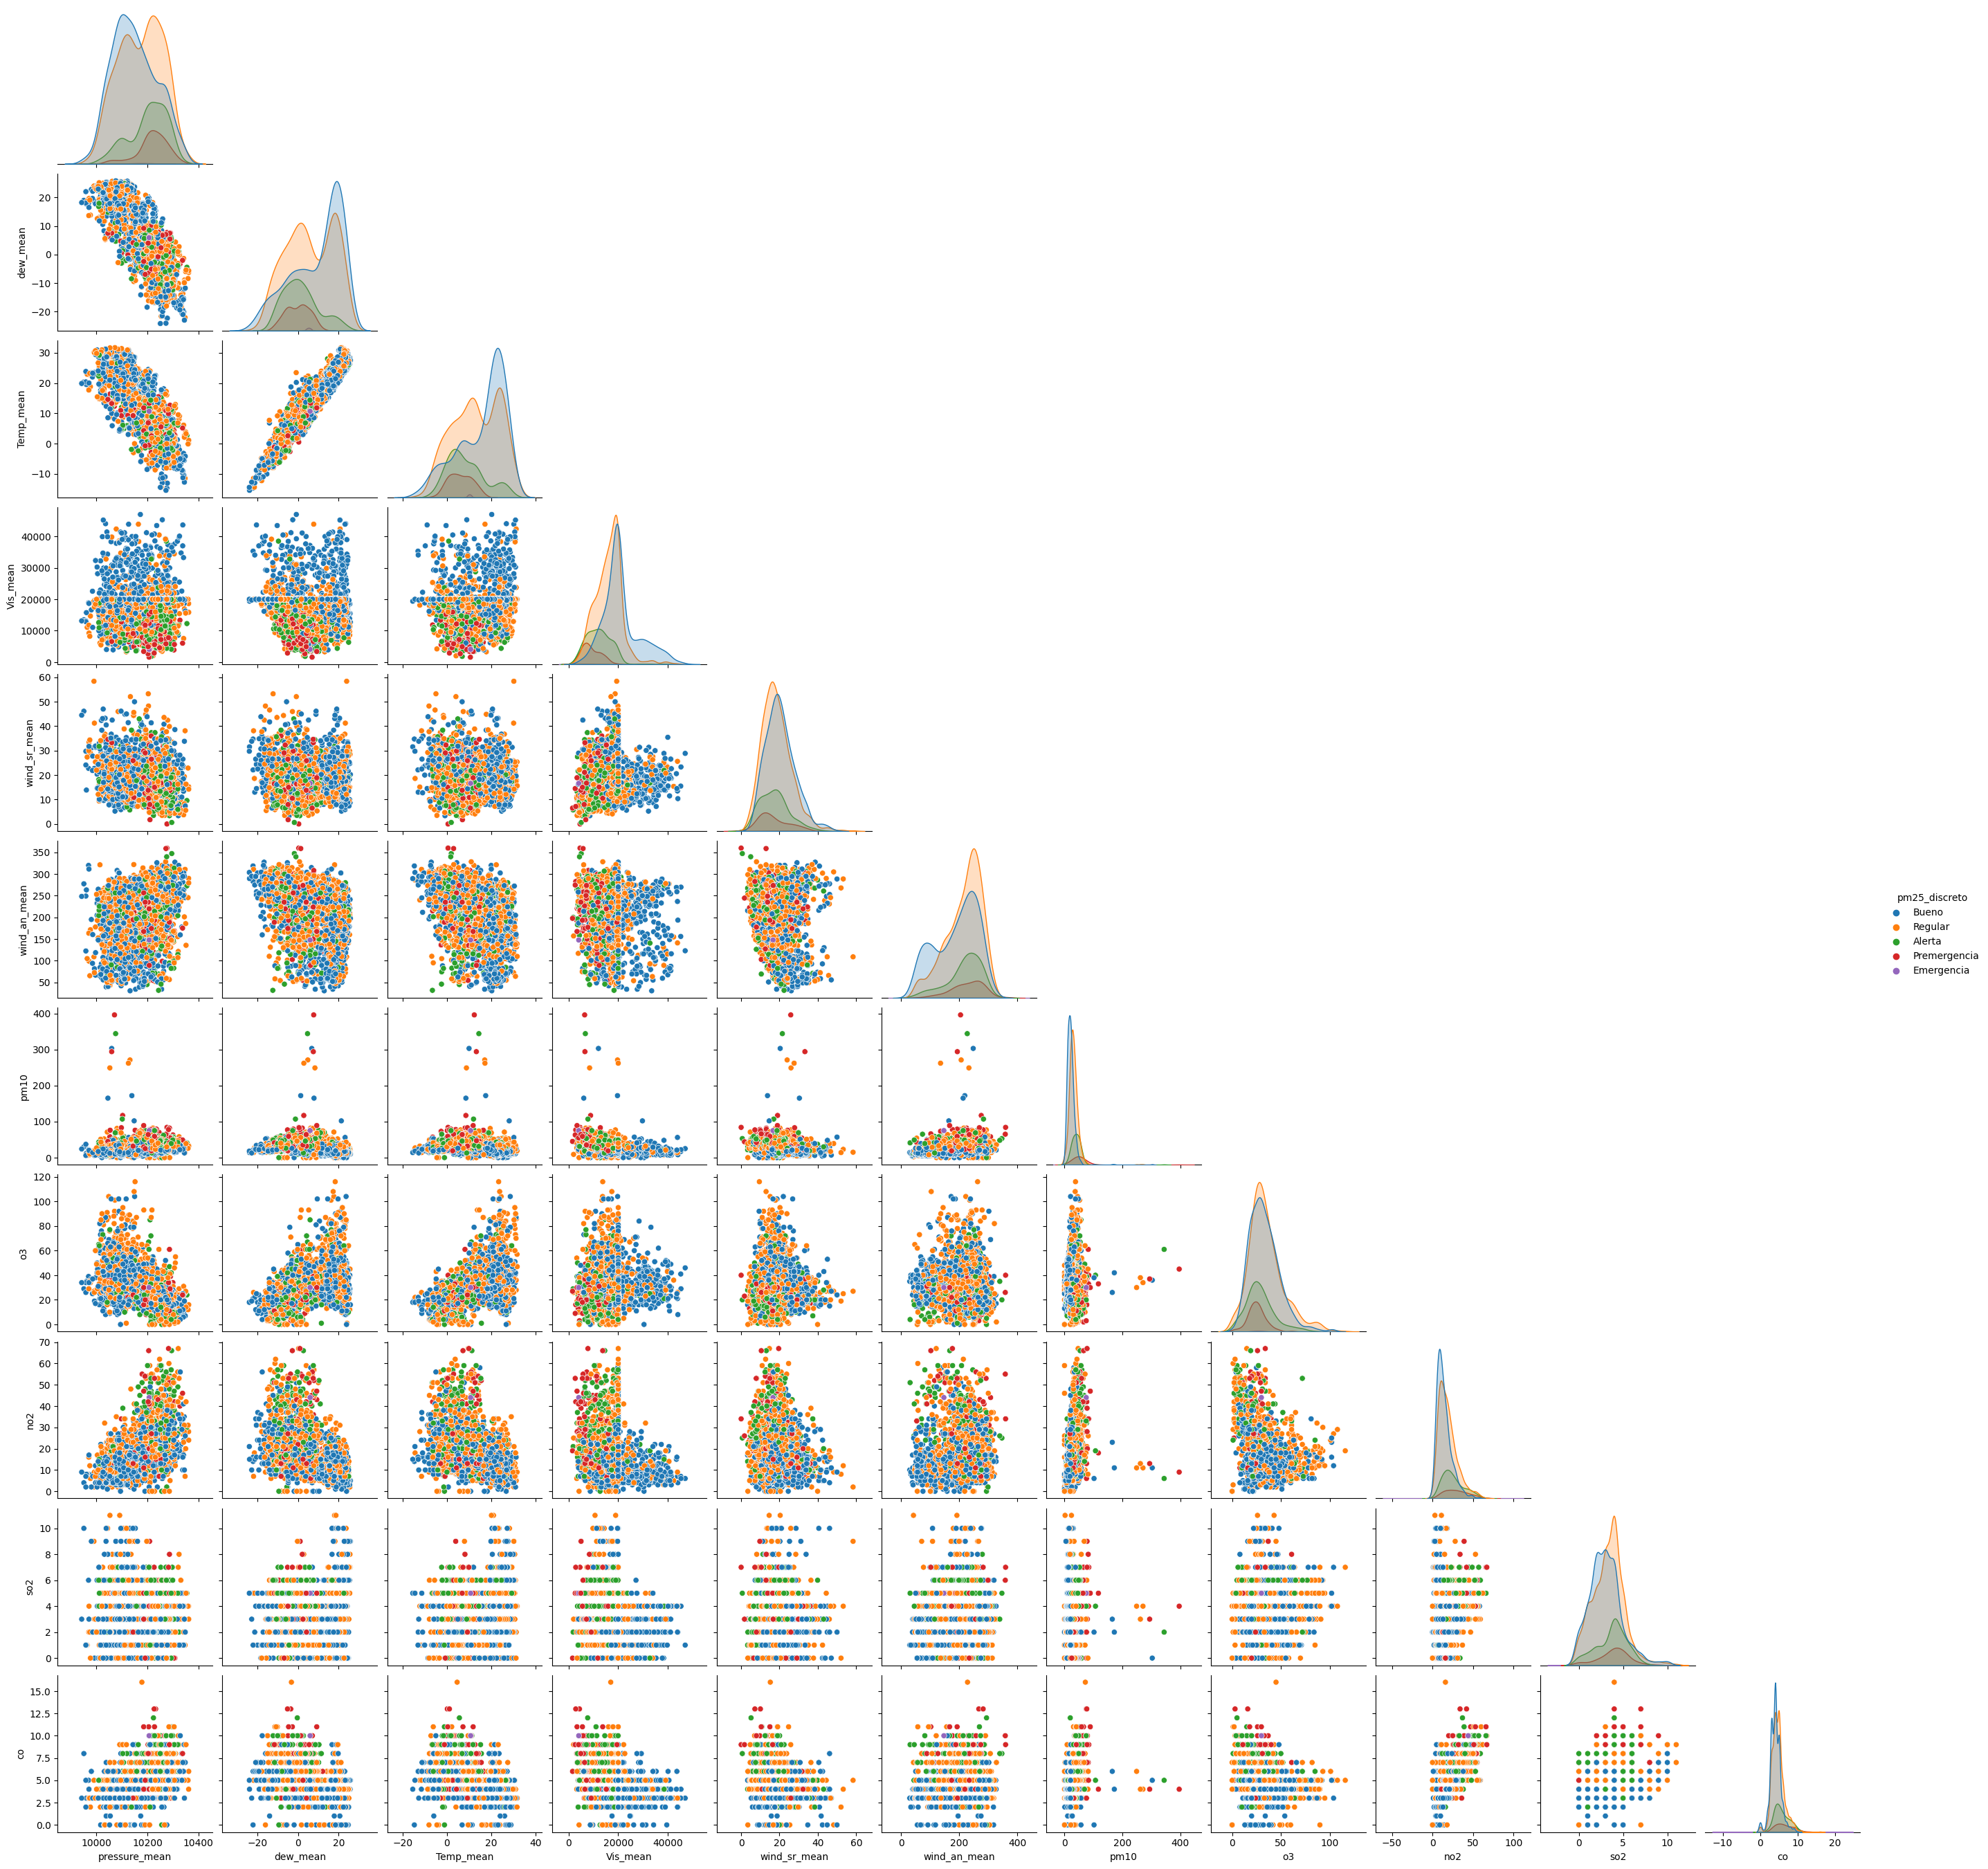

In [172]:
pairplot(data[['pressure_mean', 'dew_mean', 'Temp_mean', 'Vis_mean', 'wind_sr_mean',
       'wind_an_mean', 'pm10', 'o3', 'no2', 'so2', 'co',"pm25_discreto"]],hue="pm25_discreto",corner=True)

Se puede apreciar que ciertos valores agrupan mejor los target que otros, algo que agregar es que en la columna de vis_mean, que corresponde a la altura minima de las nubes, aparece una linea que divide ciertos datos, esto sucede, porque en una estacion su dispositivo de medicion, al parecer, llegaban hasta 2000 metros, mientras que de otra estacion, median a una mayor distancia, esto nos indica que los datos no se pueden juntar todos en un solo datasets, ya que, por el simple hecho de que no se midieron los datos con la misma instrumentación.

## Regularizacion.

Se regularizaron los datos,ya que, los datos tienen una escala distinta esto reduce el error entre ellas.

Se coprobó que un modelo con los datos inciales y omitiendo los quimicos, arrojaban un score inferiro en comparacion si agregamos todas las columnas.

In [173]:
'''columnas_x=["date",'dew_min', 'Temp_min', 'Vis_min', 'wind_sr_min', 'wind_an_min',
       'dew_max', 'Temp_max', 'Vis_max', 'wind_sr_max', 'wind_an_max',
       'pressure_mean', 'dew_mean', 'Temp_mean', 'Vis_mean',
       'wind_sr_mean', 'wind_an_mean']'''

'columnas_x=["date",\'dew_min\', \'Temp_min\', \'Vis_min\', \'wind_sr_min\', \'wind_an_min\',\n       \'dew_max\', \'Temp_max\', \'Vis_max\', \'wind_sr_max\', \'wind_an_max\',\n       \'pressure_mean\', \'dew_mean\', \'Temp_mean\', \'Vis_mean\',\n       \'wind_sr_mean\', \'wind_an_mean\']'

columnas con todos las columnas.

In [174]:
columnas_x=["date",'dew_min', 'Temp_min', 'Vis_min', 'wind_sr_min', 'wind_an_min',
       'dew_max', 'Temp_max', 'Vis_max', 'wind_sr_max', 'wind_an_max',
       'pressure_mean', 'dew_mean', 'Temp_mean', 'Vis_mean',
       'wind_sr_mean', 'wind_an_mean',"Relacion1","Relacion2","Relacion3", 'pm10', 'o3','no2', 'so2', 'co']

In [175]:
min_max_scaler = preprocessing.MinMaxScaler()


A continuacion se haran split de los datos de entramiento, validacion y testo, destacar que existen 2 datos de entrenamiento para cada ciiudad, unos en formato pandas y otro en array, esto para no elimnar las fechas y poder plotear el target en funcion de esta.

### Seoul:

In [176]:
df_seoul_X_tr,  df_seoul_X_test,  df_seoul_y_tr,  df_seoul_y_test  =  train_test_split(data.loc["SEOUL CITY, KS"][columnas_x],data.loc["SEOUL CITY, KS"]["pm25_discreto"],test_size=.2,random_state=97)

Split de datos de entramiento y validaciòn.

In [177]:
df_seoul_X_tr,  df_seoul_X_val,  df_seoul_y_tr,  df_seoul_y_val  =  train_test_split(df_seoul_X_tr,df_seoul_y_tr,test_size=.2,random_state=97)

Datos de los features regularizados.

In [178]:
seoul_X_tr = min_max_scaler.fit_transform(df_seoul_X_tr[columnas_x[1:]])
seoul_X_test = min_max_scaler.fit_transform(df_seoul_X_test[columnas_x[1:]])
seoul_X_val = min_max_scaler.fit_transform(df_seoul_X_val[columnas_x[1:]])

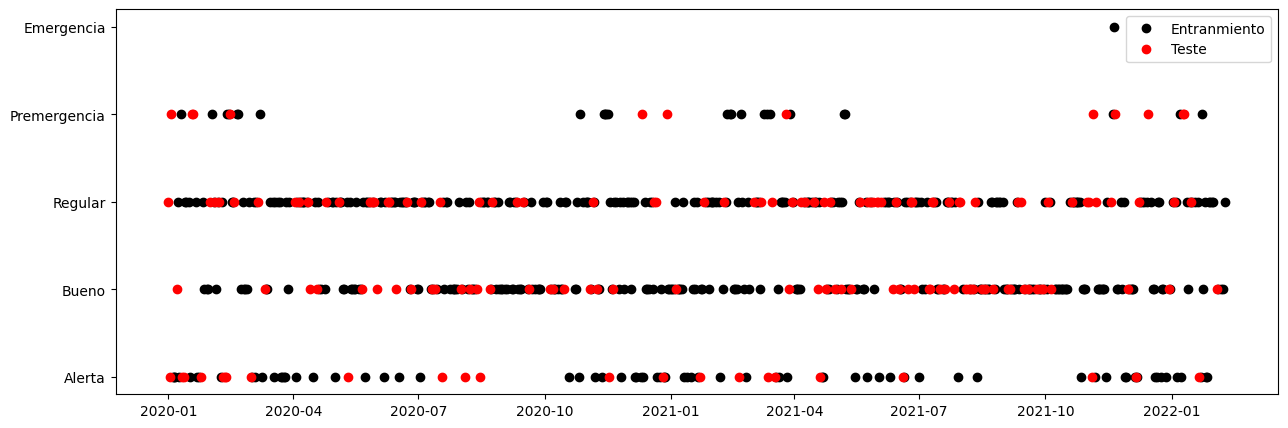

In [179]:
fig = plt.figure(figsize=(15,5))
plt.plot(df_seoul_X_tr["date"],df_seoul_y_tr,"ok",label="Entranmiento")
plt.plot(df_seoul_X_test["date"],df_seoul_y_test,"or",label="Teste")
plt.legend()

Este procemiento se repitio para las demas ciudades

### Suwon

In [181]:
df_suwon_X_tr,  df_suwon_X_test,  df_suwon_y_tr,  df_suwon_y_test  =  train_test_split(data.loc["SUWON, KS"][columnas_x],data.loc["SUWON, KS"]["pm25_discreto"],test_size=.2,random_state=97)

In [182]:
df_suwon_X_tr,  df_suwon_X_val,  df_suwon_y_tr,  df_suwon_y_val  =  train_test_split(df_suwon_X_tr,df_suwon_y_tr,test_size=.2,random_state=97)

In [183]:
suwon_X_tr = min_max_scaler.fit_transform(df_suwon_X_tr[columnas_x[1:]])
suwon_X_test = min_max_scaler.fit_transform(df_suwon_X_test[columnas_x[1:]])
suwon_X_val = min_max_scaler.fit_transform(df_suwon_X_val[columnas_x[1:]])

### Cheongju

In [184]:
df_cheongju_X_tr,  df_cheongju_X_test,  df_cheongju_y_tr,df_cheongju_y_test  =  train_test_split(data.loc["CHEONGJU, KS"][columnas_x],data.loc["CHEONGJU, KS"]["pm25_discreto"],test_size=.2,random_state=97)

In [185]:
df_cheongju_X_tr,  df_cheongju_X_val,  df_cheongju_y_tr,  df_cheongju_y_val  =  train_test_split(df_cheongju_X_tr,df_cheongju_y_tr,test_size=.2,random_state=97)

In [186]:
cheongju_X_tr = min_max_scaler.fit_transform(df_cheongju_X_tr[columnas_x[1:]])
cheongju_X_test = min_max_scaler.fit_transform(df_cheongju_X_test[columnas_x[1:]])
cheongju_X_val = min_max_scaler.fit_transform(df_cheongju_X_val[columnas_x[1:]])


## Random Forest

Hiper-parametros

> n estimators: se eligiò es rango, ya que, se emepzo con uno mas grande, pero se fue reduciendo a medida que se iba ejecutando.


> max feature: El nuemro de features, al ser alrededor de 21 y ser un numero grande, es probable que se neccesite un valor superior (8), que el valor de la raiz cuadrada.


> max_depth: Nuevamente al tener varias columnas, se supuso que la profundidar podria ser un un numero grande, por lo que se eligieron los valores ¨None,15,20".



> ccp_alpha: Se quizo estudiar si al cambiar el valor de coste minimo, mejoraba el modelo, considerando el valor por defecto :0.0





> bootstrap: Se escogio False, para que cada arbol tuviera todos los datos para su construccion.












In [187]:
n_estimators=[int(x) for x in np.linspace(100,300,3)]
max_features=[None,"sqrt",10]
max_depth=[None,15,20]
criterion=["gini", "entropy"]
ccp_alpha=[0.0,0.5]
min_samples_split=[5,8]
bootstrap=[False]

### Seoul:

In [188]:
'''param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
                "ccp_alpha":ccp_alpha,
               "criterion":criterion,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}
print(param_grid)

rf_Model = RandomForestClassifier()
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 5)
rf_Grid.fit(seoul_X_tr,  df_seoul_y_tr)
print("Los mejores parametros son :",rf_Grid.best_params_,"Score :",rf_Grid.best_score_)'''

'param_grid = {\'n_estimators\': n_estimators,\n               \'max_features\': max_features,\n               \'max_depth\': max_depth,\n                "ccp_alpha":ccp_alpha,\n               "criterion":criterion,\n               \'min_samples_split\': min_samples_split,\n               \'bootstrap\': bootstrap}\nprint(param_grid)\n\nrf_Model = RandomForestClassifier()\nrf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 5)\nrf_Grid.fit(seoul_X_tr,  df_seoul_y_tr)\nprint("Los mejores parametros son :",rf_Grid.best_params_,"Score :",rf_Grid.best_score_)'

Por la cantidad de parametros el tiempo de ejecucion demora mucho, se comentò, los mejores parametros para el random forest son los siguientes:

In [189]:
rf=RandomForestClassifier(bootstrap= False,ccp_alpha= 0.0,max_depth=None,criterion= 'gini',max_features="sqrt",min_samples_split=8,n_estimators=100)

Entrenamiento con los datos de entreamiento

In [190]:
rf.fit(seoul_X_tr,df_seoul_y_tr)

RandomForestClassifier(bootstrap=False, min_samples_split=8)

Score datos de validacion.

In [191]:
rf.score(seoul_X_val,df_seoul_y_val)

0.34959349593495936

Testeo

Matriz de confusion con los datos de testeo

In [192]:
cm=confusion_matrix(df_seoul_y_test,rf.predict(seoul_X_test))

In [193]:
 from sklearn.metrics import classification_report
 from sklearn.metrics import ConfusionMatrixDisplay

In [194]:
df_seoul_y_test.value_counts()

Regular         64
Bueno           55
Alerta          23
Premergencia    12
Name: pm25_discreto, dtype: int64

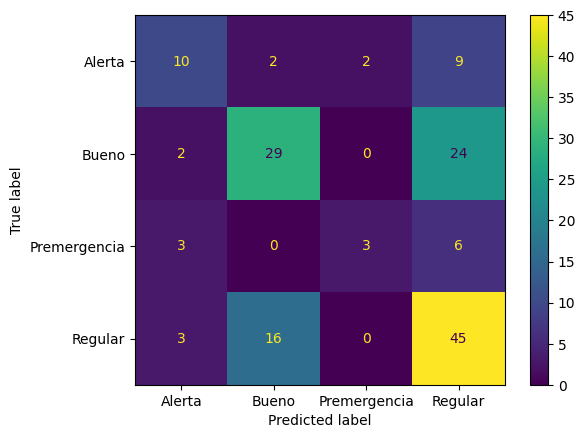

In [195]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Alerta","Bueno","Premergencia","Regular",])
disp.plot()

Se aprecia que los datos "bueno" variaban entre "bueno" y regular", mientras que "regular" fue el que mas preciso fue.

Plot de superpociiòn entre los datos de testeo y la predicion del modelo Random Forest.

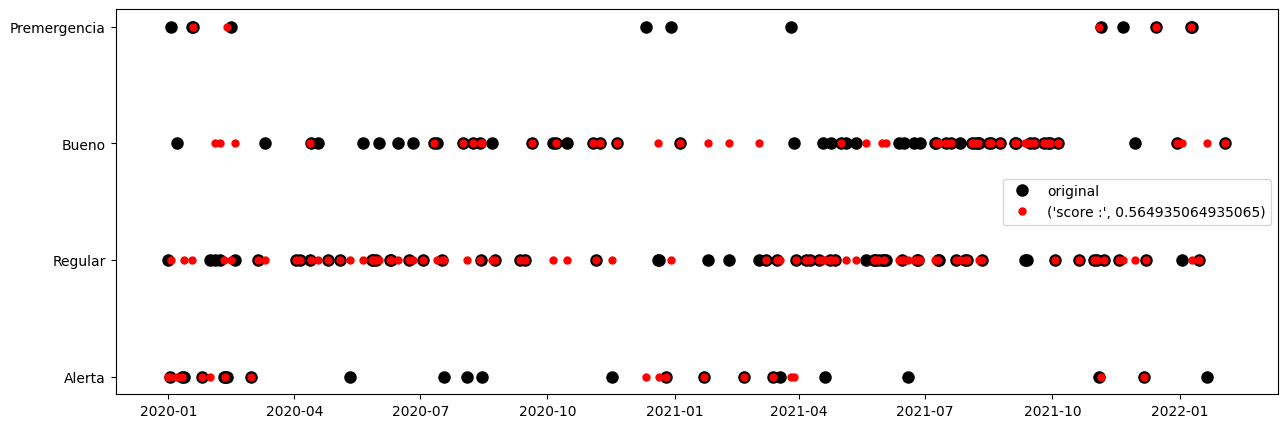

In [196]:
fig = plt.figure(figsize=(15,5))
plt.plot(df_seoul_X_test["date"],df_seoul_y_test,"ok",label="original",ms=8)
plt.plot(df_seoul_X_test["date"],rf.predict(seoul_X_test),"or",label=("score :",rf.score(seoul_X_test, df_seoul_y_test)),ms=5)
plt.legend()

### Suwon:

In [197]:
'''param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               "ccp_alpha":ccp_alpha,
               "criterion":criterion,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}
print(param_grid)

rf_Model = RandomForestClassifier()
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 5)
rf_Grid.fit(suwon_X_tr,  df_suwon_y_tr)
print("Los mejores parametros son :",rf_Grid.best_params_,"Score :",rf_Grid.best_score_)'''

'param_grid = {\'n_estimators\': n_estimators,\n               \'max_features\': max_features,\n               \'max_depth\': max_depth,\n               "ccp_alpha":ccp_alpha,\n               "criterion":criterion,\n               \'min_samples_split\': min_samples_split,\n               \'bootstrap\': bootstrap}\nprint(param_grid)\n\nrf_Model = RandomForestClassifier()\nrf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 5)\nrf_Grid.fit(suwon_X_tr,  df_suwon_y_tr)\nprint("Los mejores parametros son :",rf_Grid.best_params_,"Score :",rf_Grid.best_score_)'

In [198]:
rf=RandomForestClassifier(bootstrap=False,ccp_alpha= 0.0,criterion= 'entropy',max_depth=15,max_features="sqrt",min_samples_split=8,n_estimators=100)

In [199]:
rf.fit(suwon_X_tr,df_suwon_y_tr)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=15,
                       min_samples_split=8)

In [200]:
rf.score(suwon_X_val,df_suwon_y_val)

0.6210526315789474

Testeo

In [201]:
cm=confusion_matrix(df_suwon_y_test,rf.predict(suwon_X_test))

In [202]:
df_suwon_y_test.value_counts()

Regular         59
Bueno           36
Alerta          19
Premergencia     5
Name: pm25_discreto, dtype: int64

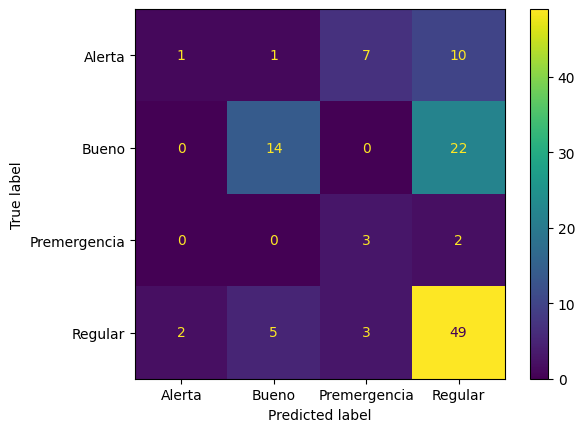

In [203]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Alerta","Bueno","Premergencia","Regular",])
disp.plot()

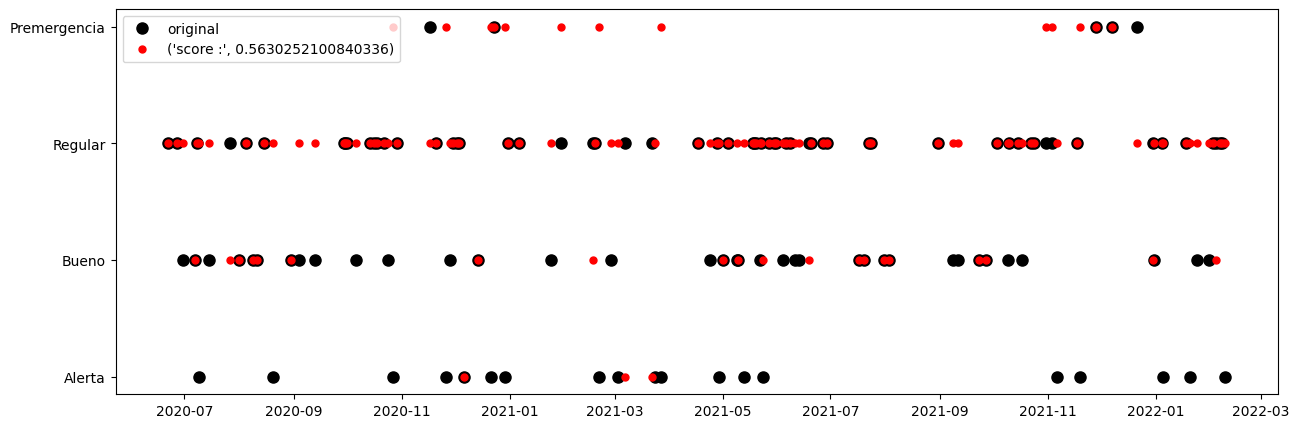

In [204]:
fig = plt.figure(figsize=(15,5))
plt.plot(df_suwon_X_test["date"],df_suwon_y_test,"ok",label="original",ms=8)
plt.plot(df_suwon_X_test["date"],rf.predict(suwon_X_test),"or",label=("score :",rf.score(suwon_X_test, df_suwon_y_test)),ms=5)
plt.legend()

### Cheongju:

In [205]:
'''param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               "ccp_alpha":ccp_alpha,
               'max_depth': max_depth,
               "criterion":criterion,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}
print(param_grid)

rf_Model = RandomForestClassifier()
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 5)
rf_Grid.fit(cheongju_X_tr,  df_cheongju_y_tr)
print("Los mejores parametros son :",rf_Grid.best_params_,"Score :",rf_Grid.best_score_)'''

'param_grid = {\'n_estimators\': n_estimators,\n               \'max_features\': max_features,\n               "ccp_alpha":ccp_alpha,\n               \'max_depth\': max_depth,\n               "criterion":criterion,\n               \'min_samples_split\': min_samples_split,\n               \'bootstrap\': bootstrap}\nprint(param_grid)\n\nrf_Model = RandomForestClassifier()\nrf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 5)\nrf_Grid.fit(cheongju_X_tr,  df_cheongju_y_tr)\nprint("Los mejores parametros son :",rf_Grid.best_params_,"Score :",rf_Grid.best_score_)'

In [206]:
rf=RandomForestClassifier(bootstrap=False,ccp_alpha=0.0,criterion= 'entropy',max_depth=15,max_features="sqrt",min_samples_split=8,n_estimators=100)

In [207]:
rf.fit(cheongju_X_tr,df_cheongju_y_tr)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=15,
                       min_samples_split=8)

In [208]:
rf.score(cheongju_X_val,df_cheongju_y_val)

0.6341463414634146

Testeo

In [209]:
cm=confusion_matrix(df_cheongju_y_test,rf.predict(cheongju_X_test))

In [210]:
df_cheongju_y_test.value_counts()

Regular         65
Bueno           64
Alerta          22
Premergencia     3
Name: pm25_discreto, dtype: int64

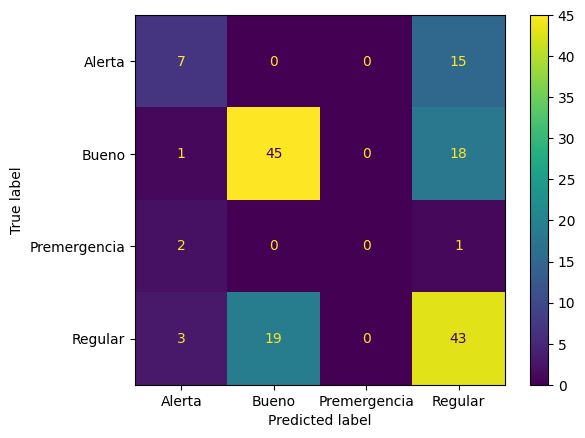

In [211]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Alerta","Bueno","Premergencia","Regular",])
disp.plot()

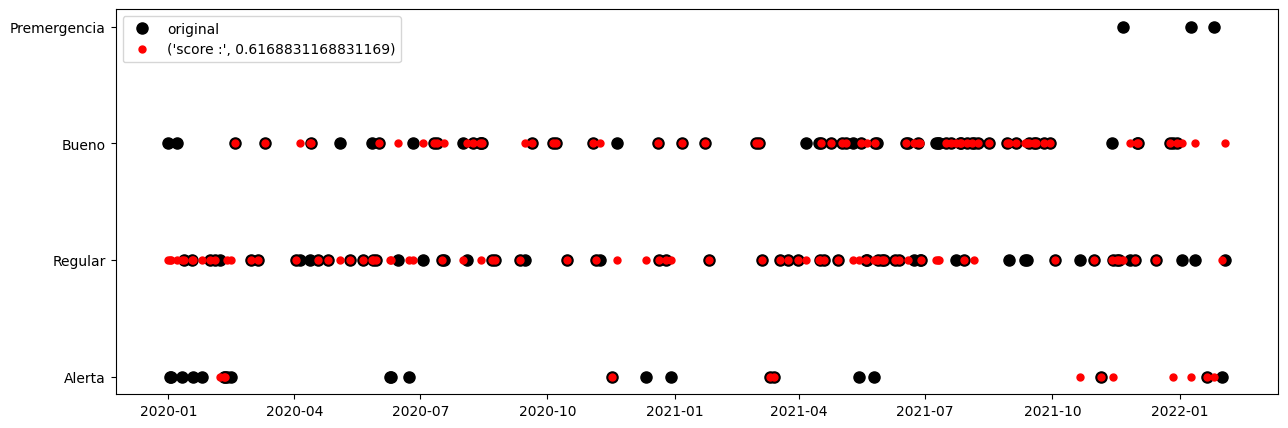

In [212]:
fig = plt.figure(figsize=(15,5))
plt.plot(df_cheongju_X_test["date"],df_cheongju_y_test,"ok",label="original",ms=8)
plt.plot(df_cheongju_X_test["date"],rf.predict(cheongju_X_test),"or",label=("score :",rf.score(cheongju_X_test, df_cheongju_y_test)),ms=5)
plt.legend()

## SVM

In [213]:
parameters = {
    'gamma' : [0.001,0.05, 0.1,0.2,'scale', 'auto'],
    'C' : [ 0.5, 0.1, 1, 7],
    "kernel":["linear", "poly", "rbf", "sigmoid"]
}

### Seoul

In [214]:
  support_vector_grid=svm.SVC()
  grid_svc = GridSearchCV(support_vector_grid, parameters,verbose=2, n_jobs = 5,cv=5)
  grid_svc.fit(seoul_X_tr, df_seoul_y_tr)
  print("Los mejores parametros son :",grid_svc.best_params_,"Score :",grid_svc.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Los mejores parametros son : {'C': 1, 'gamma': 'scale', 'kernel': 'poly'} Score : 0.5935064935064934


Los mejores parametros son los siguientes:

In [215]:
Support_vector=svm.SVC(C=1,gamma="scale",kernel="poly")
Support_vector.fit(seoul_X_tr,df_seoul_y_tr)

SVC(C=1, kernel='poly')

Score de los datos de validacion.

In [216]:
Support_vector.score(seoul_X_val,df_seoul_y_val)

0.35772357723577236

Testeo:

Matriz de confusion.

In [217]:
cm=confusion_matrix(df_seoul_y_test,Support_vector.predict(seoul_X_test))

In [218]:
df_seoul_y_test.value_counts()

Regular         64
Bueno           55
Alerta          23
Premergencia    12
Name: pm25_discreto, dtype: int64

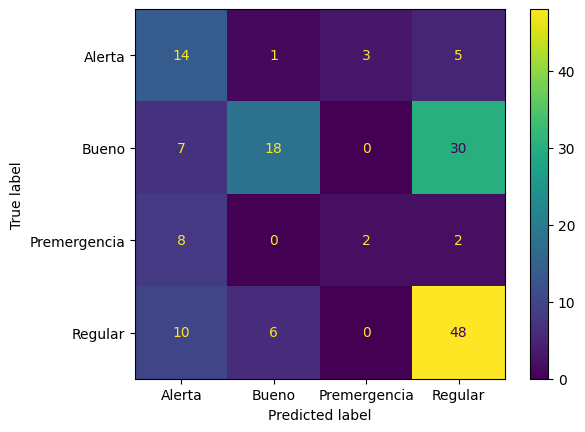

In [219]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Alerta","Bueno","Premergencia","Regular",])
disp.plot()

Plot de superpocición entre los datos de testeo y la predicion del modelo support vector machine.



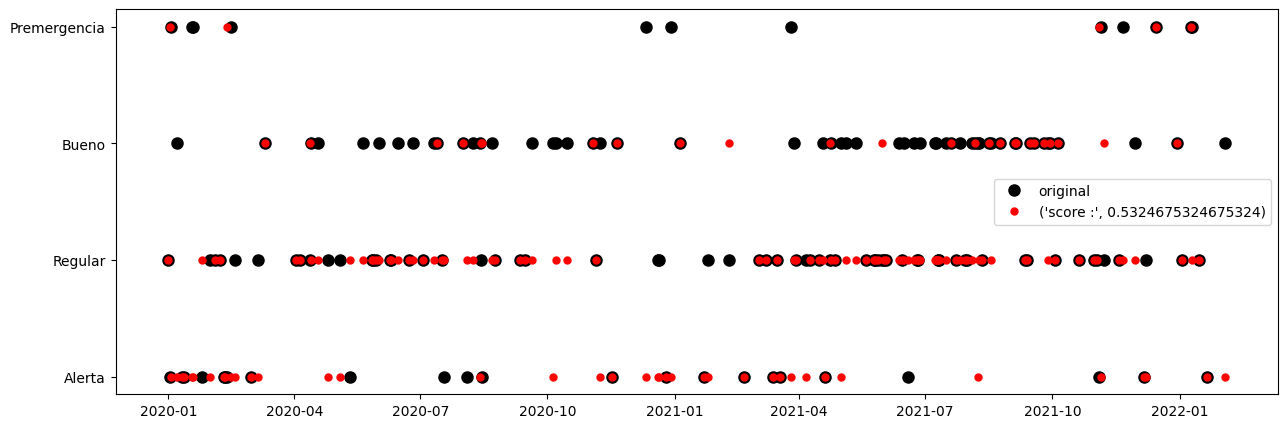

In [220]:
fig = plt.figure(figsize=(15,5))
plt.plot(df_seoul_X_test["date"],df_seoul_y_test,"ok",label="original",ms=8)
plt.plot(df_seoul_X_test["date"],Support_vector.predict(seoul_X_test),"or",label=("score :",Support_vector.score(seoul_X_test, df_seoul_y_test)),ms=5)
plt.legend()

### Suwon

In [221]:
  support_vector_grid=svm.SVC()
  grid_svc = GridSearchCV(support_vector_grid, parameters,verbose=2, n_jobs = 5,cv=5)
  grid_svc.fit(suwon_X_tr, df_suwon_y_tr)
  print("Los mejores parametros son :",grid_svc.best_params_,"Score :",grid_svc.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Los mejores parametros son : {'C': 7, 'gamma': 0.001, 'kernel': 'linear'} Score : 0.631578947368421


In [222]:
Support_vector=svm.SVC(C=7,gamma= 0.001,kernel="linear")
Support_vector.fit(suwon_X_tr,df_suwon_y_tr)

SVC(C=7, gamma=0.001, kernel='linear')

In [223]:
Support_vector.score(suwon_X_val,df_suwon_y_val)

0.6947368421052632

In [224]:
cm=confusion_matrix(df_suwon_y_test,Support_vector.predict(suwon_X_test))

In [225]:
df_suwon_y_test.value_counts()

Regular         59
Bueno           36
Alerta          19
Premergencia     5
Name: pm25_discreto, dtype: int64

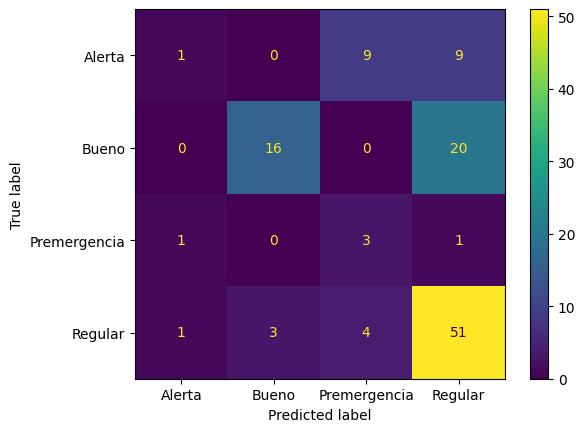

In [226]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Alerta","Bueno","Premergencia","Regular",])
disp.plot()

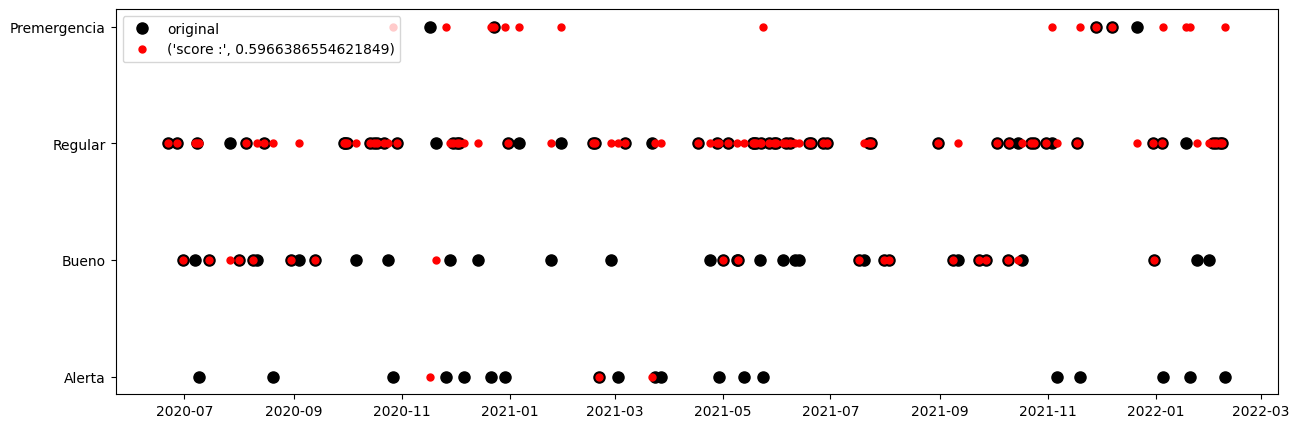

In [227]:
fig = plt.figure(figsize=(15,5))
plt.plot(df_suwon_X_test["date"],df_suwon_y_test,"ok",label="original",ms=8)
plt.plot(df_suwon_X_test["date"],Support_vector.predict(suwon_X_test),"or",label=("score :",Support_vector.score(suwon_X_test, df_suwon_y_test)),ms=5)
plt.legend()

### Cheongju

In [228]:
  support_vector_grid=svm.SVC()
  grid_svc = GridSearchCV(support_vector_grid, parameters,verbose=2, n_jobs = 5,cv=5)
  grid_svc.fit(cheongju_X_tr, df_cheongju_y_tr)
  print("Los mejores parametros son :",grid_svc.best_params_,"Score :",grid_svc.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Los mejores parametros son : {'C': 7, 'gamma': 0.001, 'kernel': 'linear'} Score : 0.69853638425067


In [229]:
Support_vector=svm.SVC(C=7,gamma=0.001,kernel="linear")
Support_vector.fit(cheongju_X_tr,df_cheongju_y_tr)

SVC(C=7, gamma=0.001, kernel='linear')

In [230]:
Support_vector.score(cheongju_X_val,df_cheongju_y_val)

0.6585365853658537

In [231]:
cm=confusion_matrix(df_cheongju_y_test,Support_vector.predict(cheongju_X_test))

In [232]:
df_cheongju_y_test.value_counts()

Regular         65
Bueno           64
Alerta          22
Premergencia     3
Name: pm25_discreto, dtype: int64

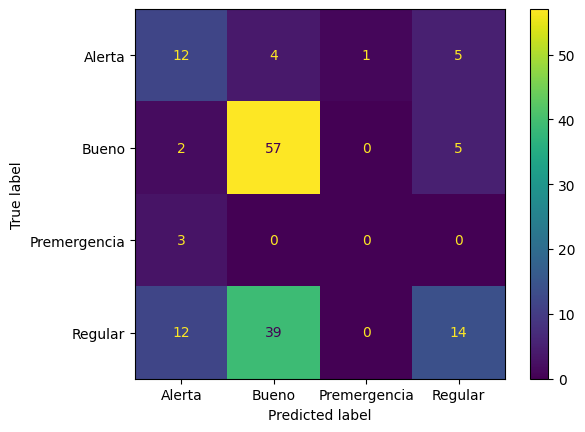

In [233]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Alerta","Bueno","Premergencia","Regular",])
disp.plot()

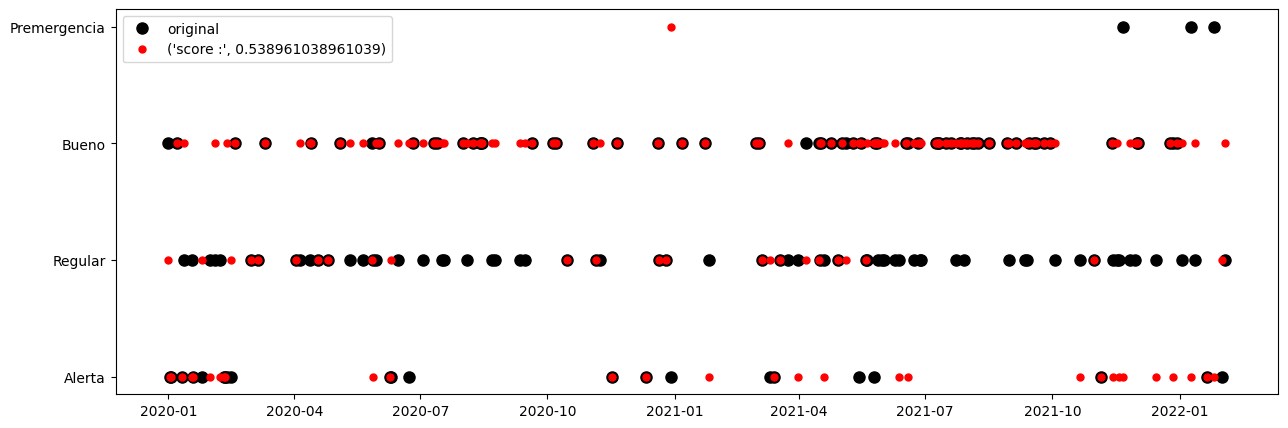

In [234]:
fig = plt.figure(figsize=(15,5))
plt.plot(df_cheongju_X_test["date"],df_cheongju_y_test,"ok",label="original",ms=8)
plt.plot(df_cheongju_X_test["date"],Support_vector.predict(cheongju_X_test),"or",label=("score :",Support_vector.score(cheongju_X_test, df_cheongju_y_test)),ms=5)
plt.legend()



---
## Discusion final.



Los modelos arrojaron en la parte de validacion, valores agradables, es decir, no extremadamente bajos ni extremadaamente altos, considerando que el set de datos tenia cierta incosistencia, ya que, eran de lugares distinto. Se podria haber conseguido un mejor resultado si, se hubiera conseguido las variables quimicas en el lugar de las estaciones, ya que afecta bastante el hecho de estar en lugares distintos, a lo mejor el viento no tenia el mismo angulo  o velocidad a 1 o 2 kilometros de distancia de la estacionm tambien considerar que la urbanizacion del lugar era diferente a donde se toman los datos, pensando que corea del sur es un pais bastante centrlizada, el simple hecho de tomar datos en diferentes lugares aumenta considerablemente el error.

Otro factor que puede haber afectado el modelo es la falta de datos o informacion, como se dijo anteriormente, la cantidad de gente en una zona y otra afecta bastante, en especial en corea del sur, a lo mejor con variables del trafico, la cantidad de habitantes o parametros de emision, hubieran arrojado mejores resultados.

Tambien un dato que se ignoró en el entrenamiento fue el dia de la semana en el que tomaron los datos, ese valor se pudo haber sacado y talves hubiera mejorado el score, ya que, el modelo hubiera intepretado cierto patrones en los dias de la semana donde existe mayor material particulado.



El mejor modelo guiandonos por el de matriz de confusion fue el random forest de *Cheongju*. Igual destacar que Suwon no fue mal encaminado en la presicion de las valores de "Premergencia", posiblemente debido a la poca cantidad de datos en comparacion con las otras ciudades.